This notebook demonstrates performance of VAR model. Model's parameters can be changed in the corresponding sections here. Prediction performance only.

In [1]:
# add path to ssa package
import sys
sys.path.append('../../..')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.api import VAR
import pathlib

import pickle

%matplotlib inline 

In [3]:
# tssa model
from src.ssa_methods.t_ssa import t_SSA

# plot with large fonts and other stuff
from src.plot.journal_style import EnableJournalStylePlotting

# data extraction methods
from src.data.accelerometer_1 import GetWalkData

# partition finding algorithms
from src.ssa_methods.ssa_complementary.ssa_multidim_partition import NextDichotomyPartition

## Data preprocessing

In [4]:
# names of observed signals
sig_names = ['$a_x$', '$a_y$', '$a_z$', '$w_x$', '$w_y$', '$w_z$']
# measure units
# acceleration is in g-units (g=9.8)
sig_units = ["m/$s^2$", "m/$s^2$", "m/$s^2$", "rad/s", "rad/s", "rad/s"]

num_signals = 6

In [5]:
# retrive signals and corresponding time grids
# this is walking motion
# first 3 components = accelerometer, last 3 - gyroscope
(train_data, time_grid_train), (test_data, time_grid_test) = GetWalkData()

print("Train len = ", train_data.shape[0])
print("Test len = ", test_data.shape[0])

Train len =  1375
Test len =  302


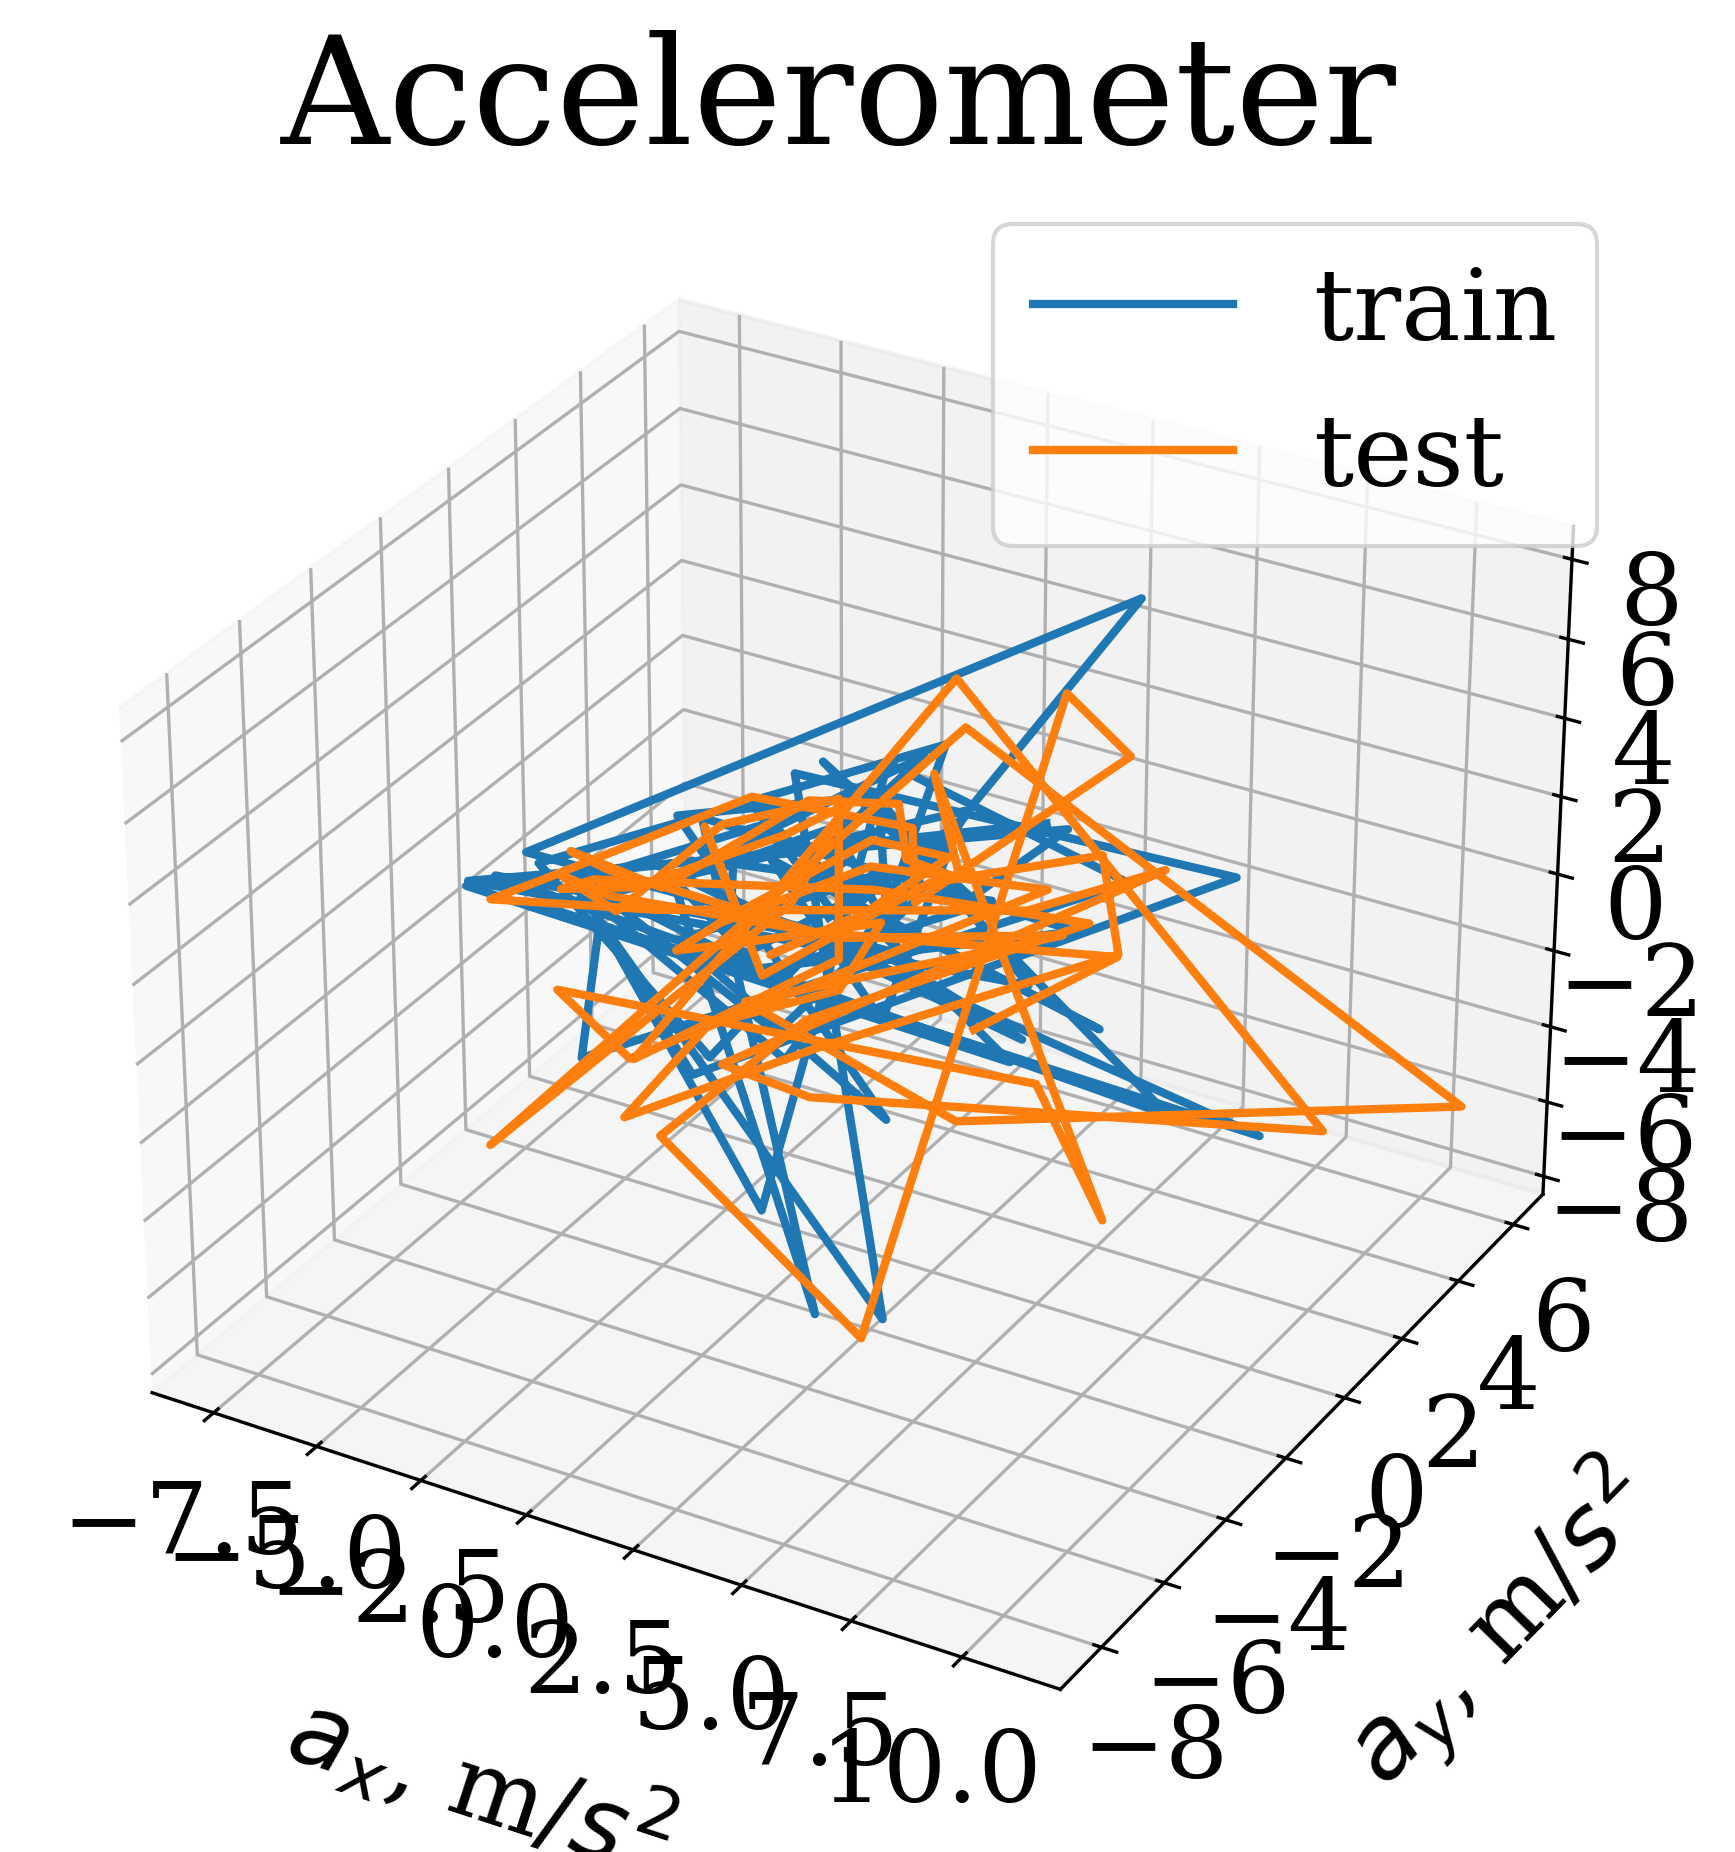

In [6]:
# draw accelerometer signals
with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection='3d')
    
    train_points = train_data.T[:3, ::20]
    test_points = test_data.T[:3, ::4]
    
    ax.plot(*train_points, label="train")
    ax.plot(*test_points, label="test")
    
    ax.set_xlabel(f"{sig_names[0]}, {sig_units[0]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[1]}, {sig_units[1]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[2]}, {sig_units[2]}", labelpad=21)
    ax.set_title("Accelerometer")
    ax.legend()

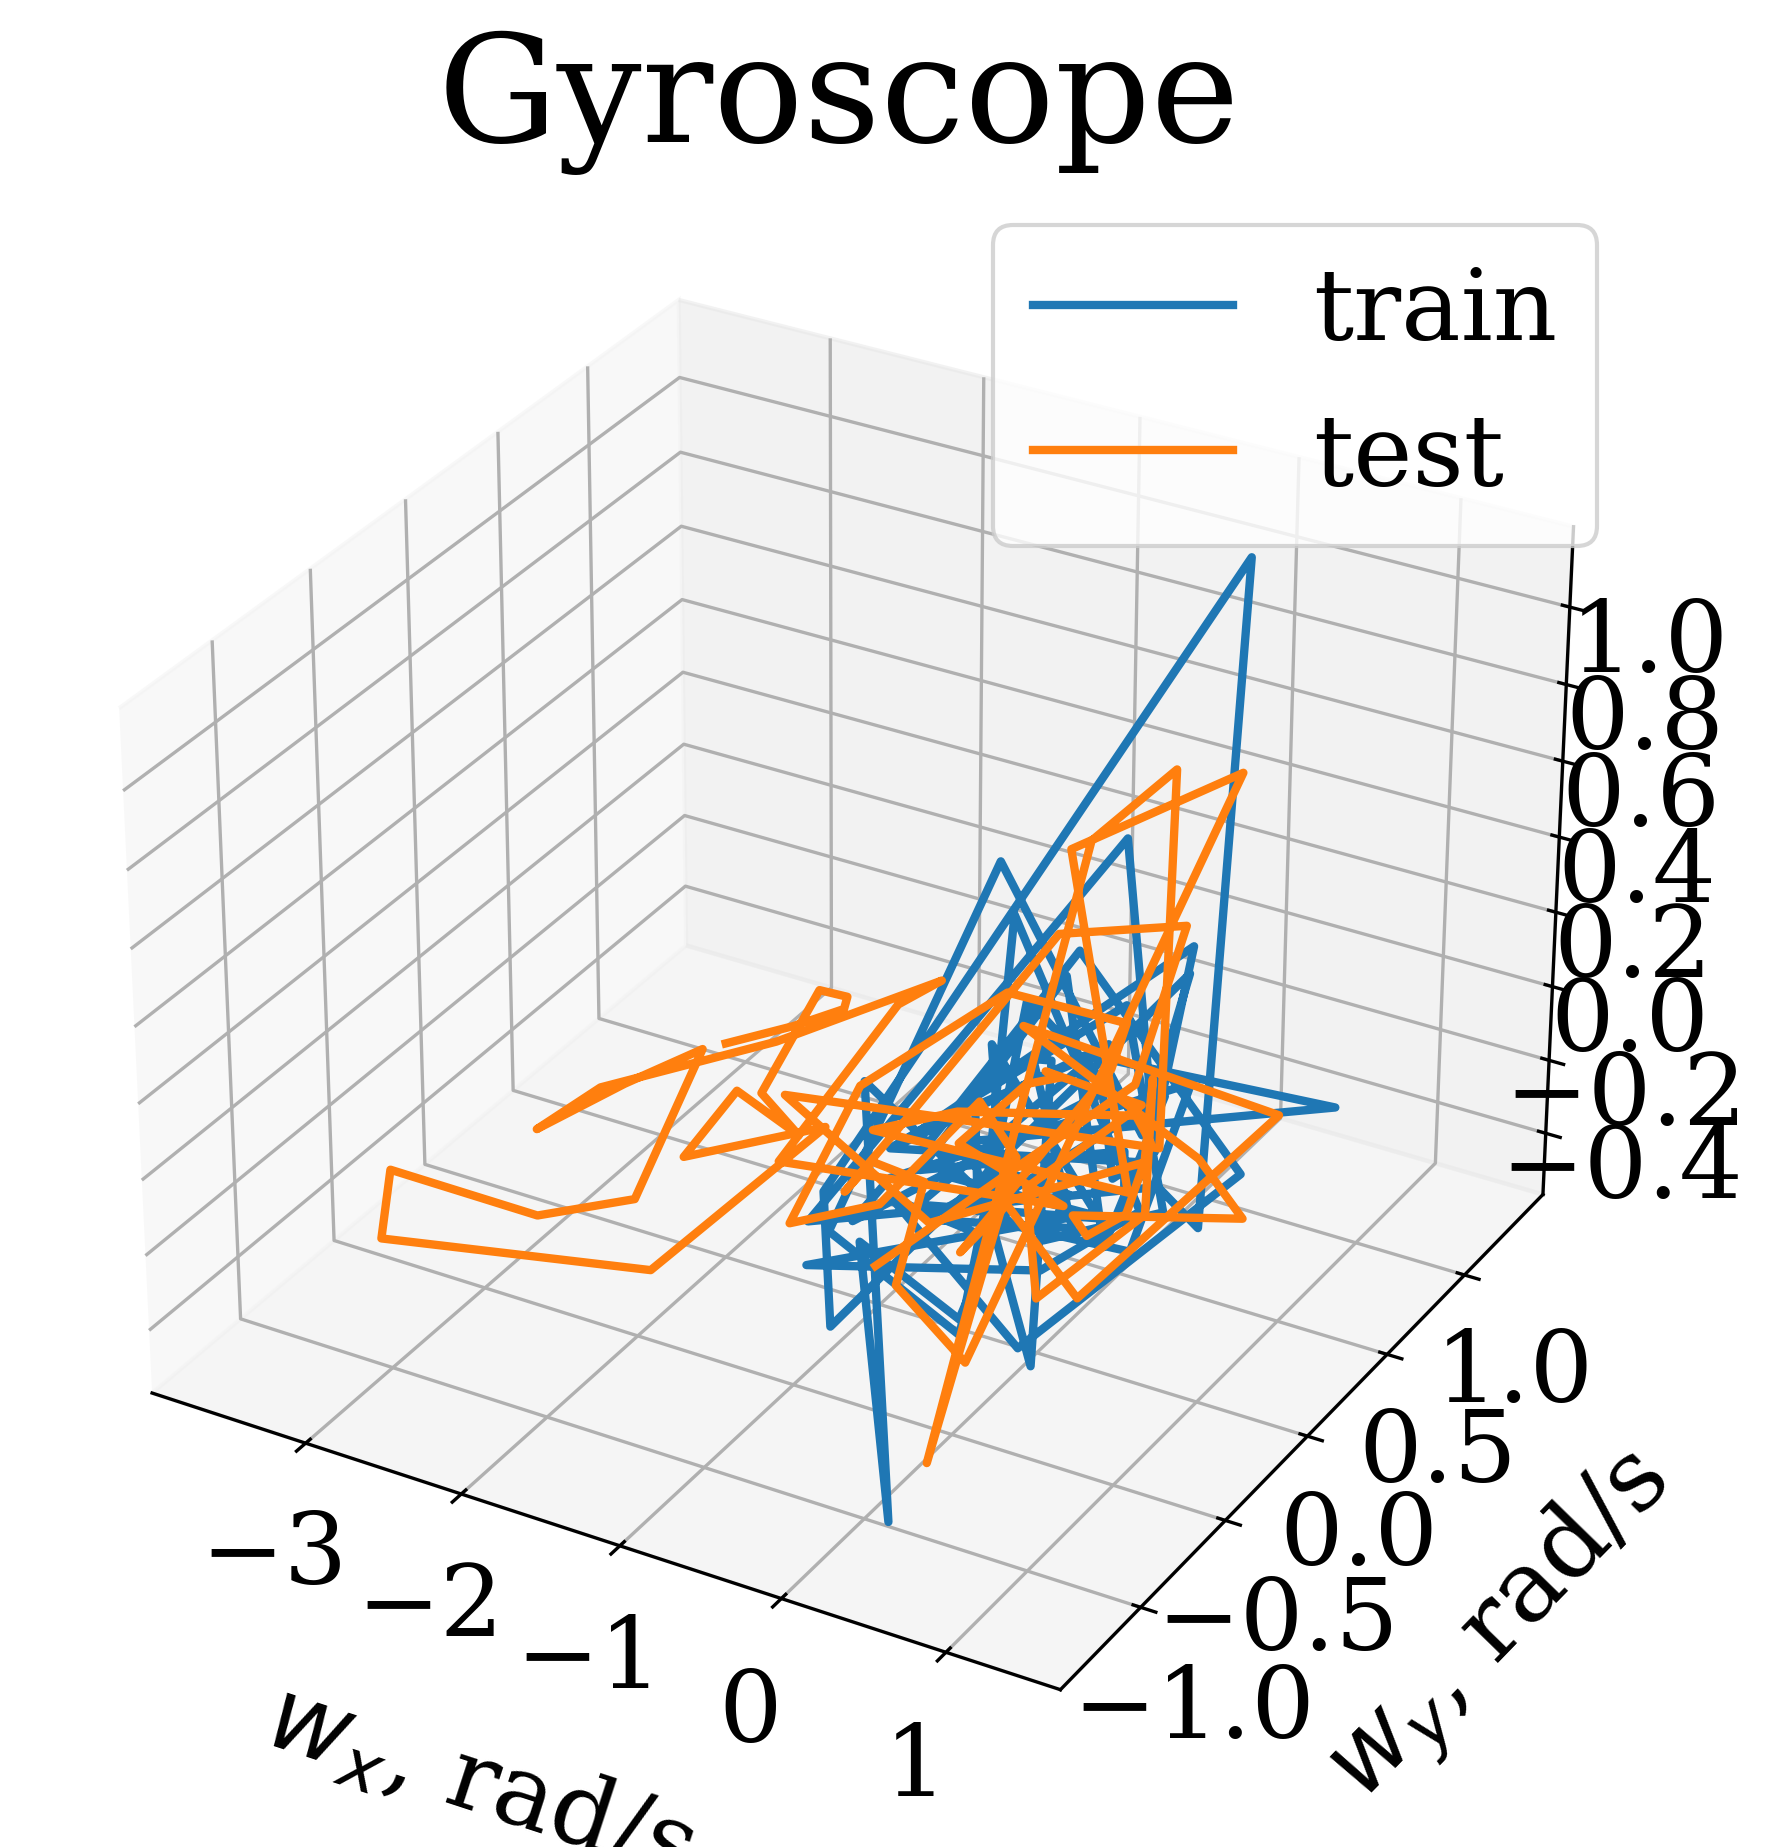

In [7]:
# draw gyro signals
with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection='3d')

    train_points = train_data.T[3:, ::20]
    test_points = test_data.T[3:, ::4]

    ax.plot(*train_points, label="train")
    ax.plot(*test_points, label="test")

    ax.set_xlabel(f"{sig_names[3]}, {sig_units[3]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[4]}, {sig_units[4]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[5]}, {sig_units[5]}", labelpad=21)
    ax.set_title("Gyroscope")
    ax.legend()

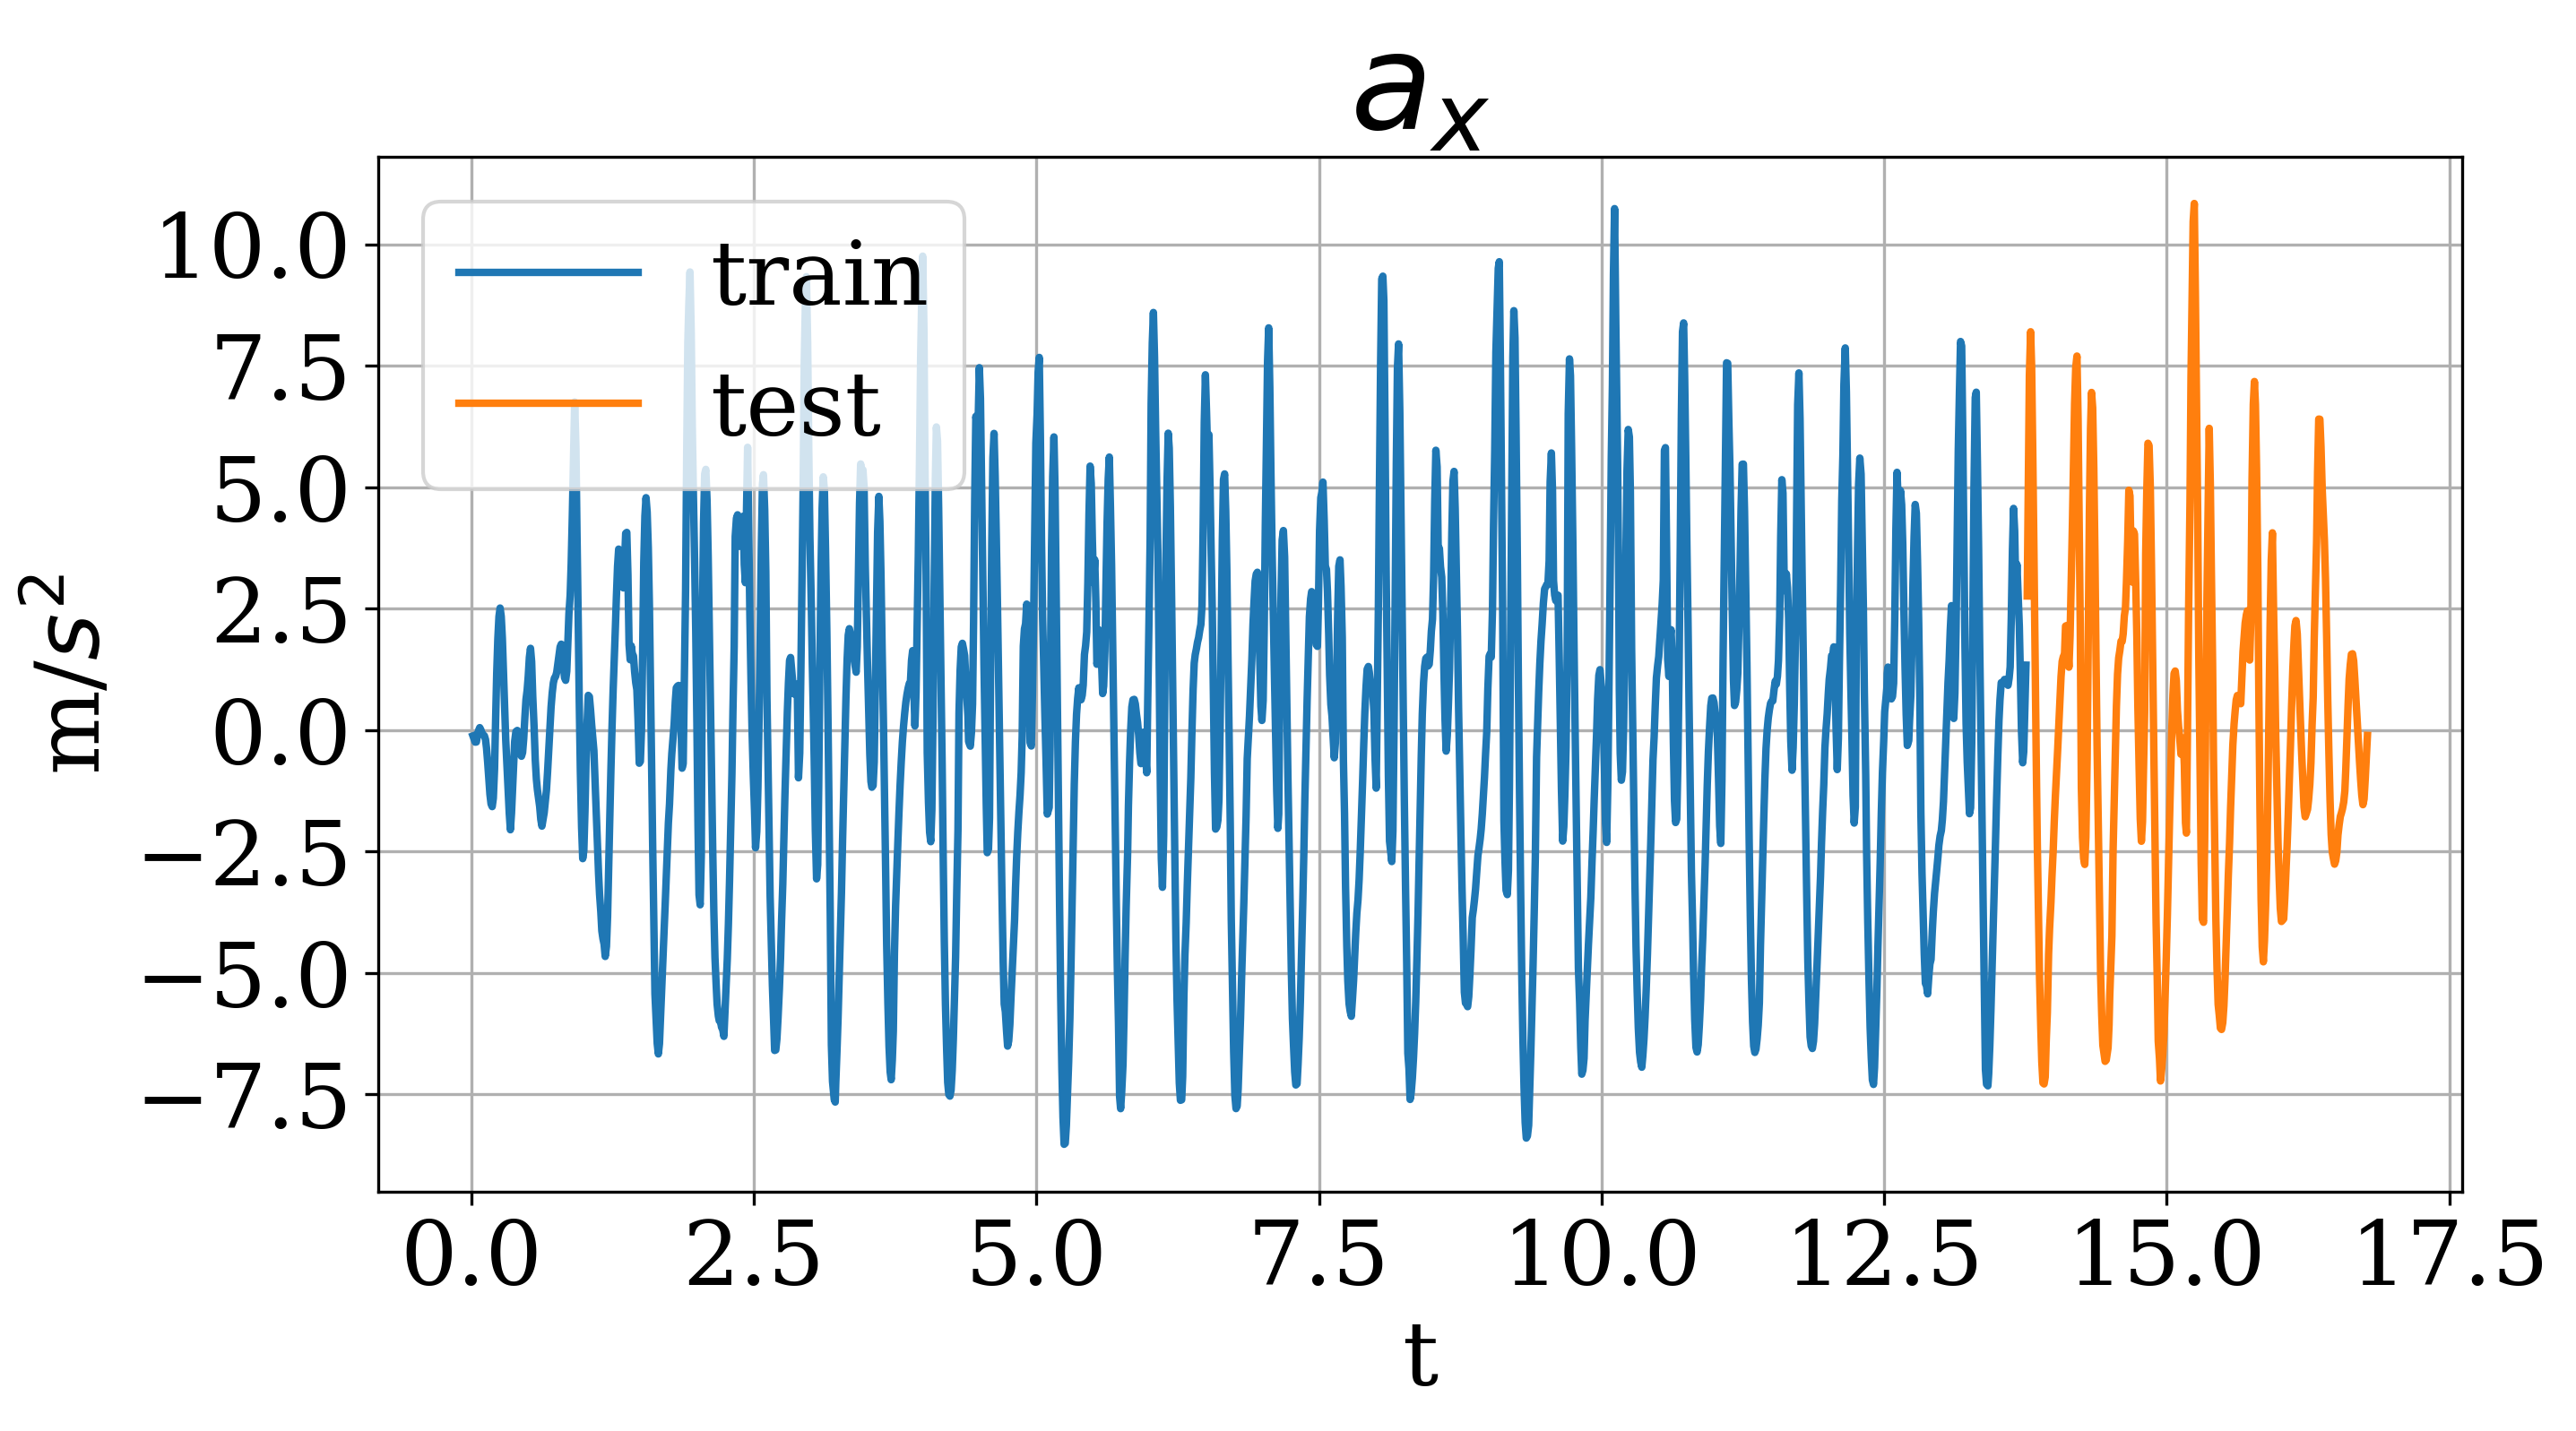

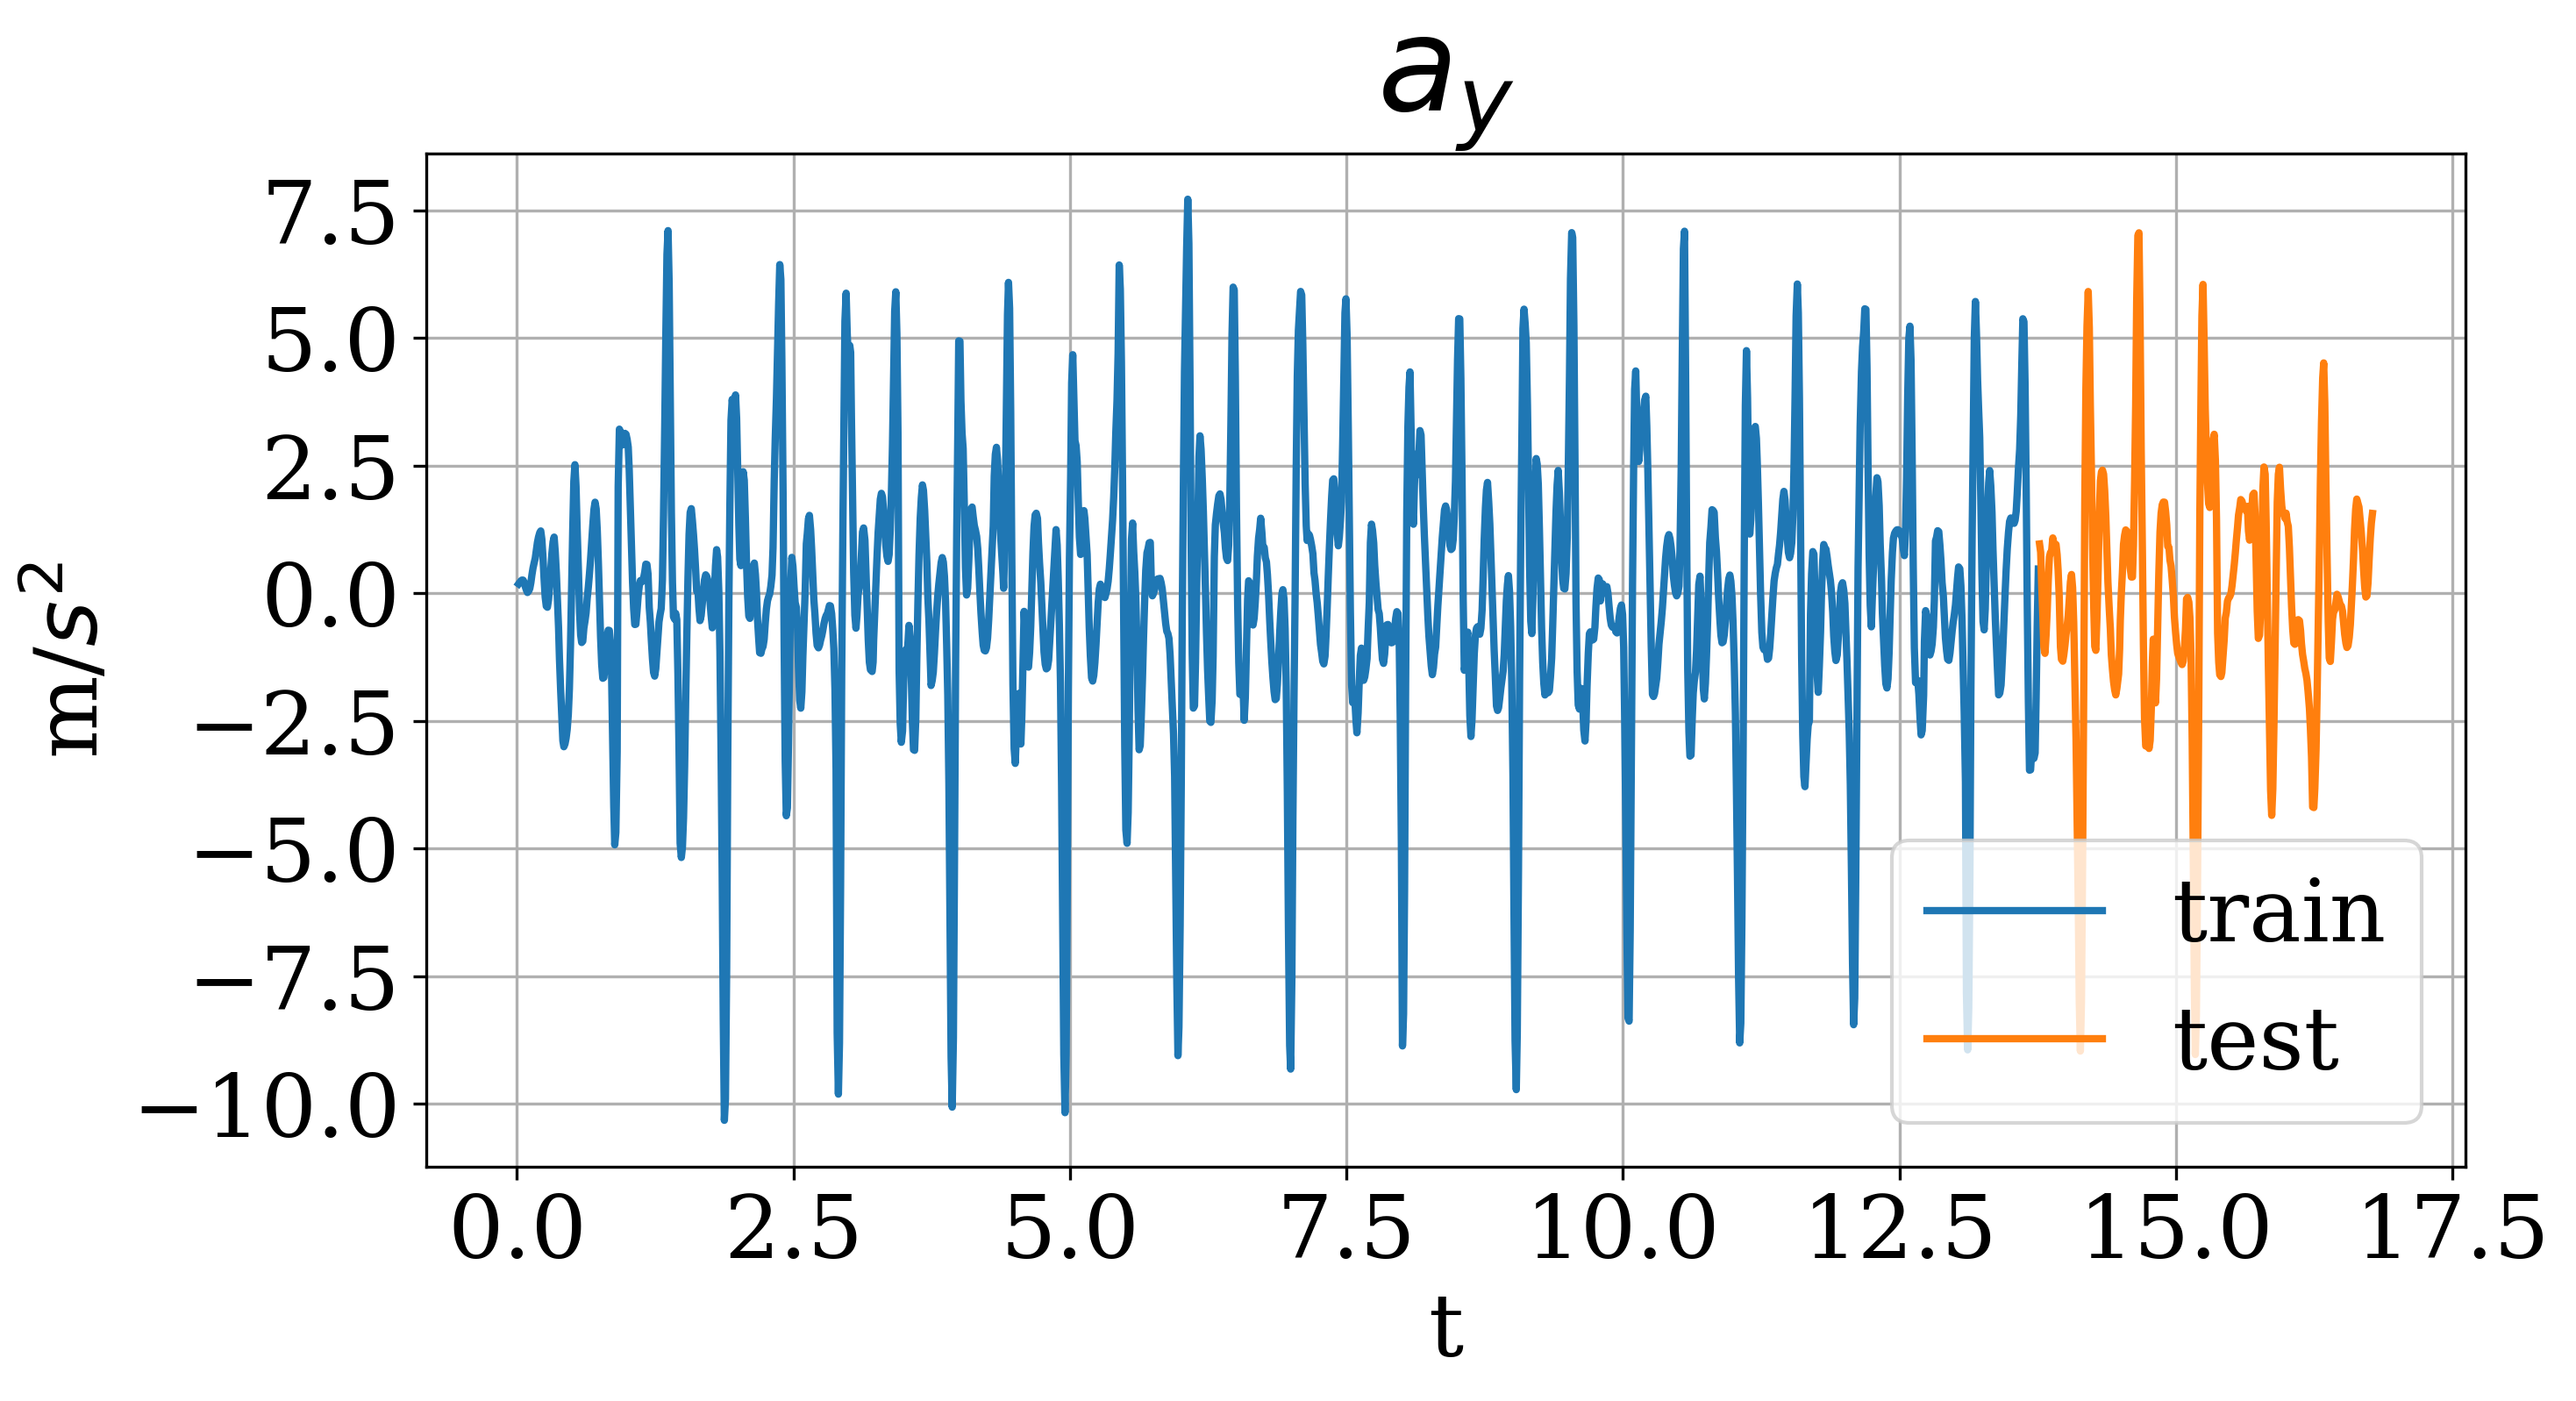

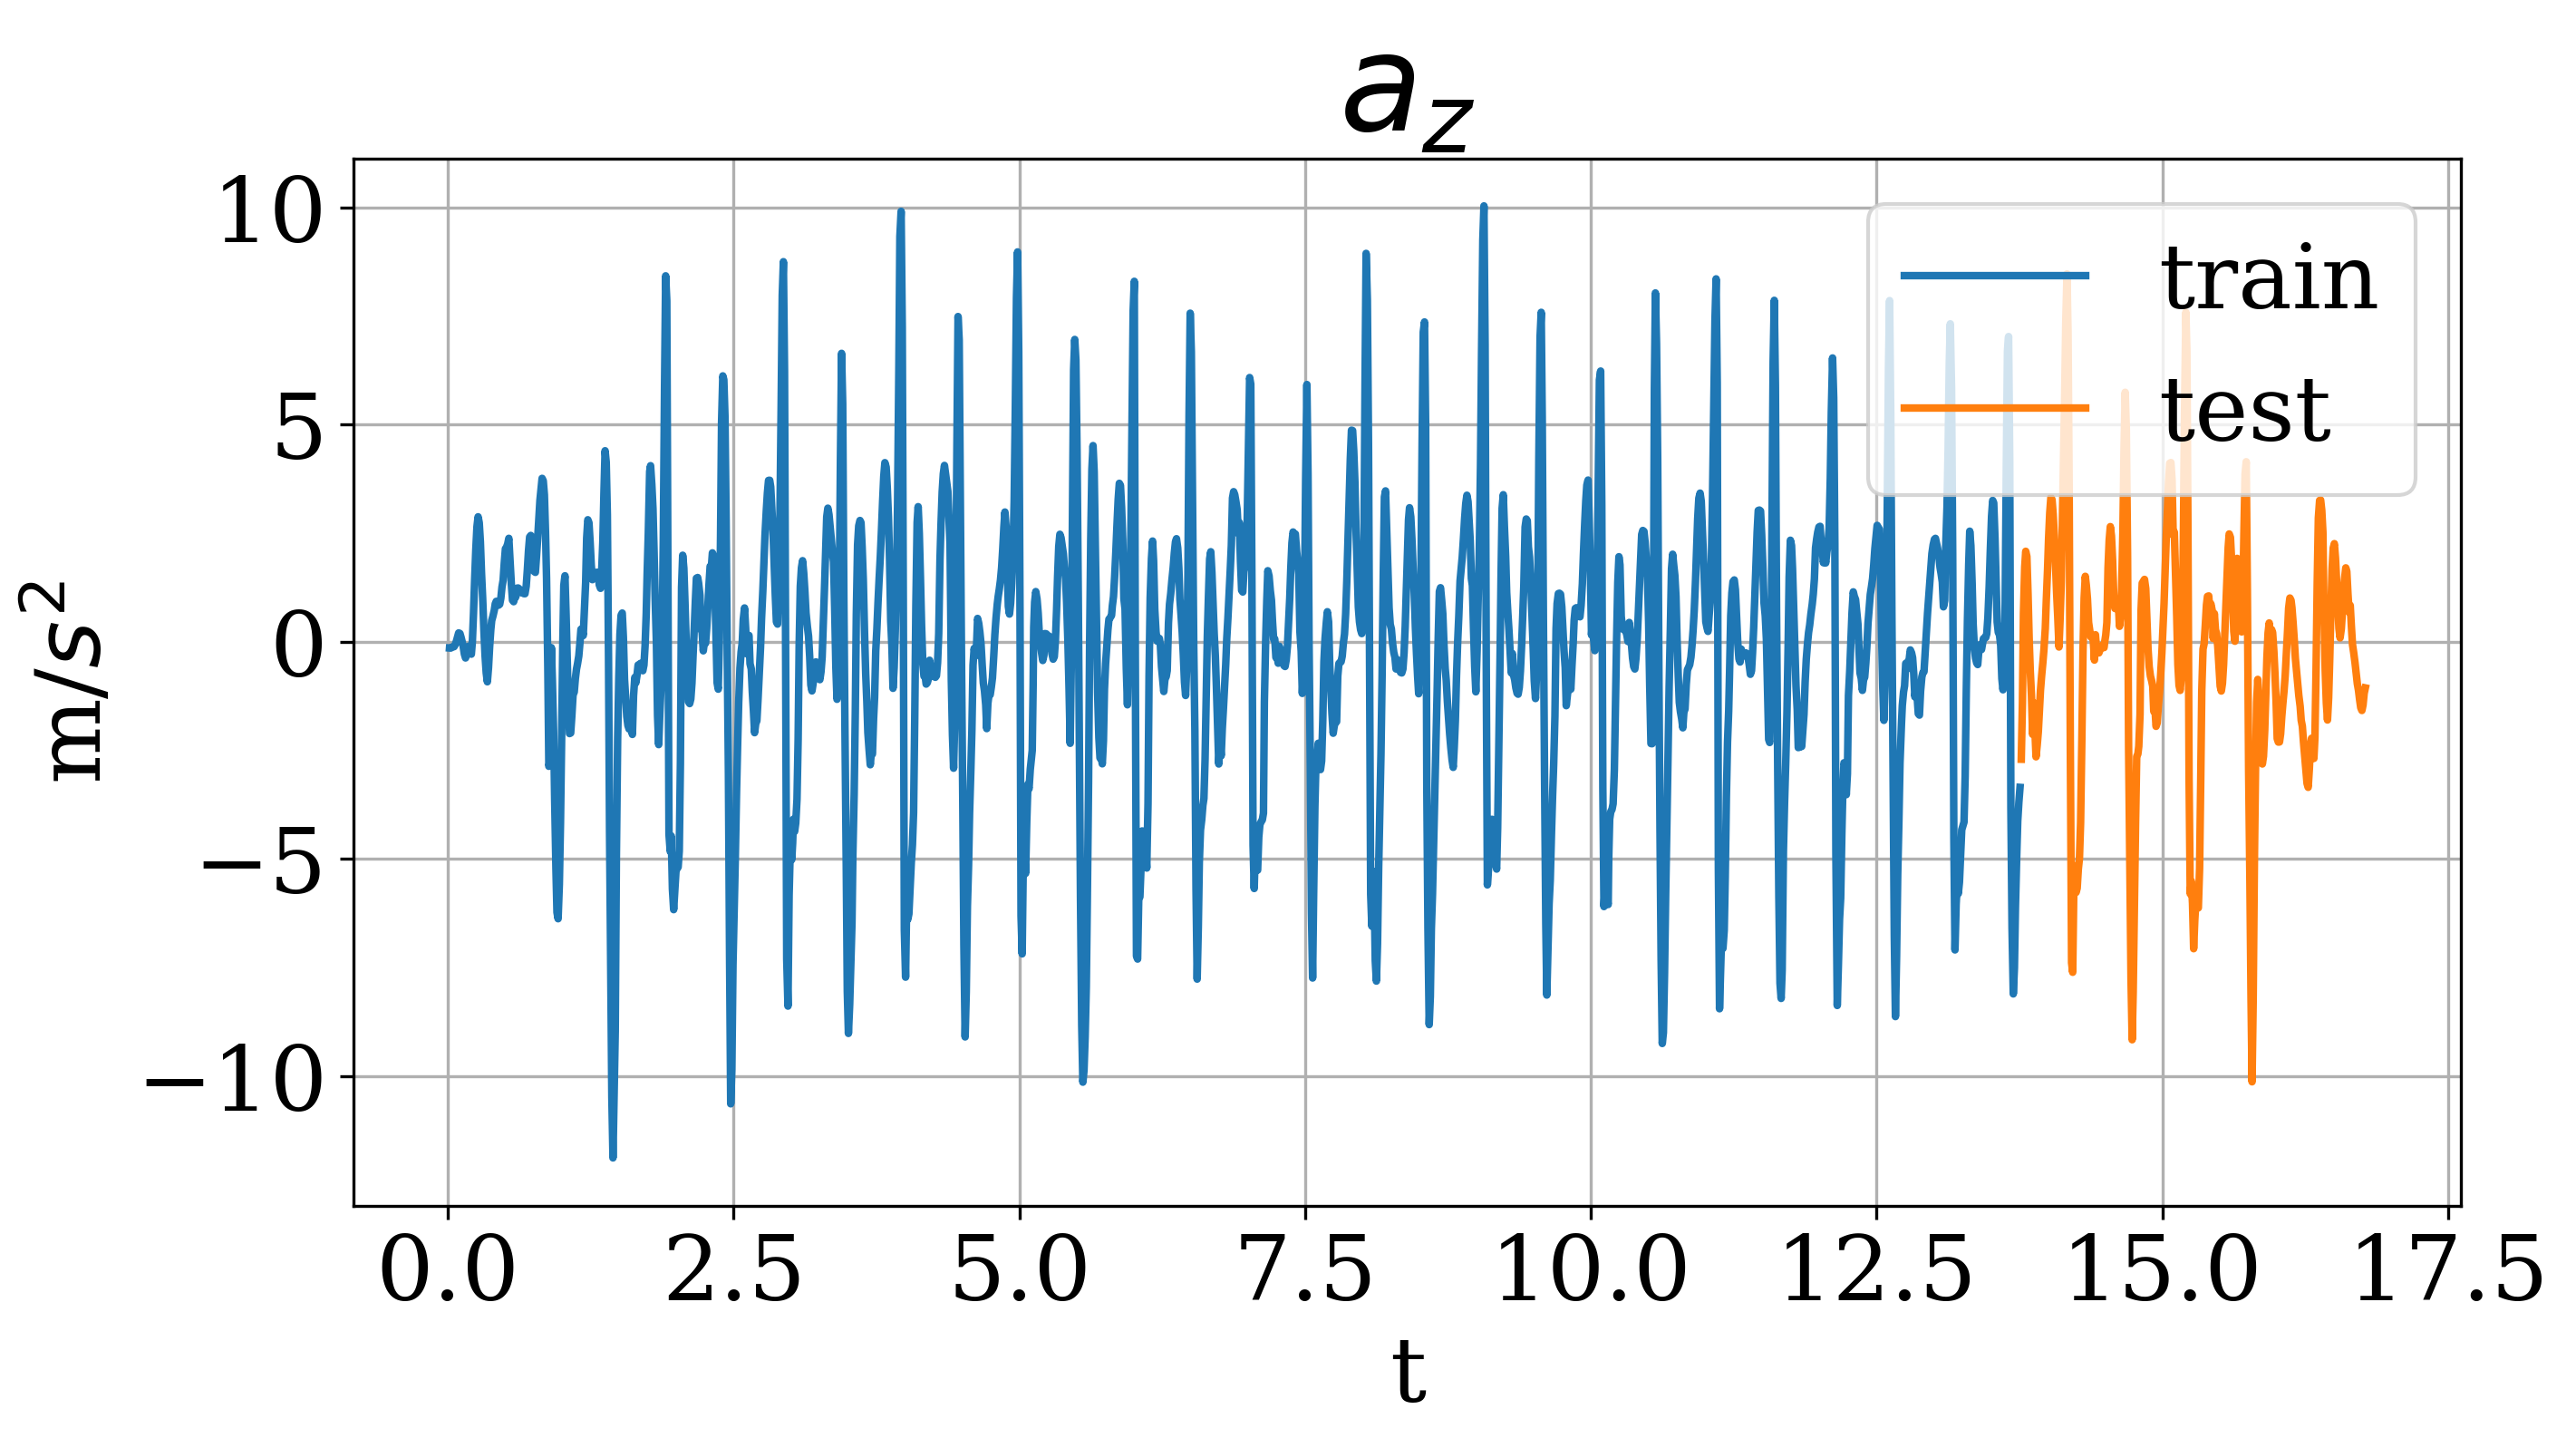

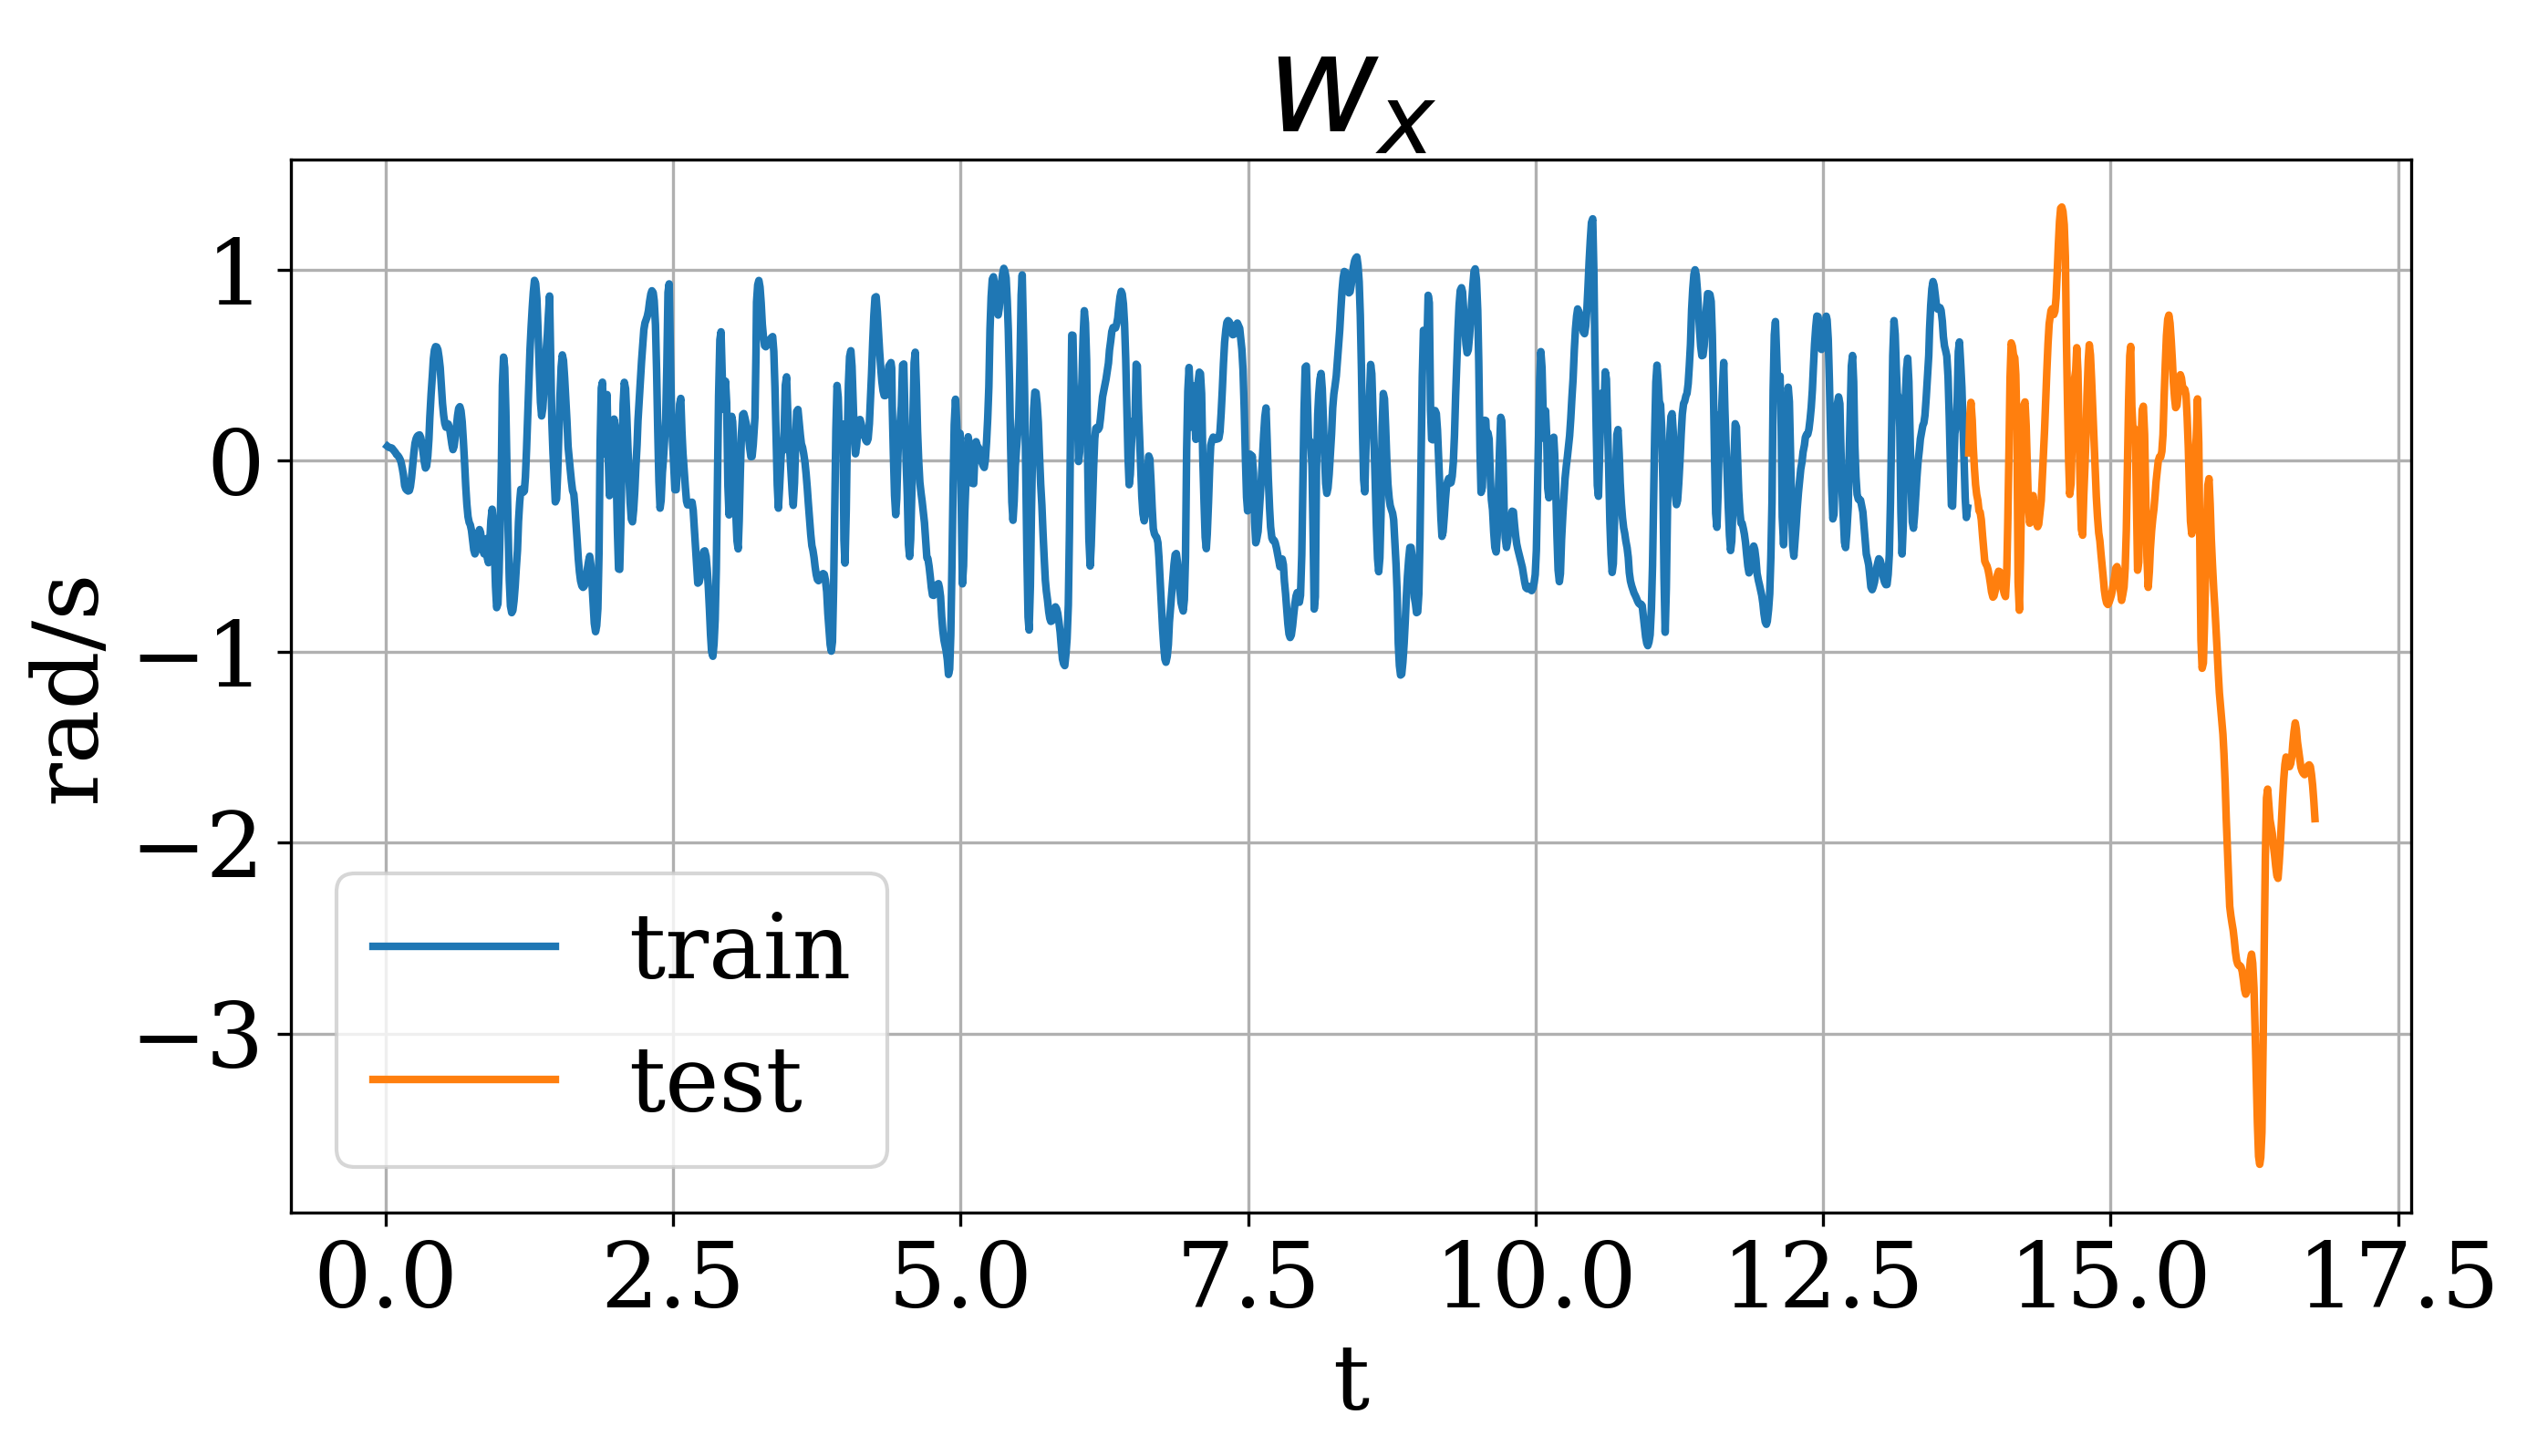

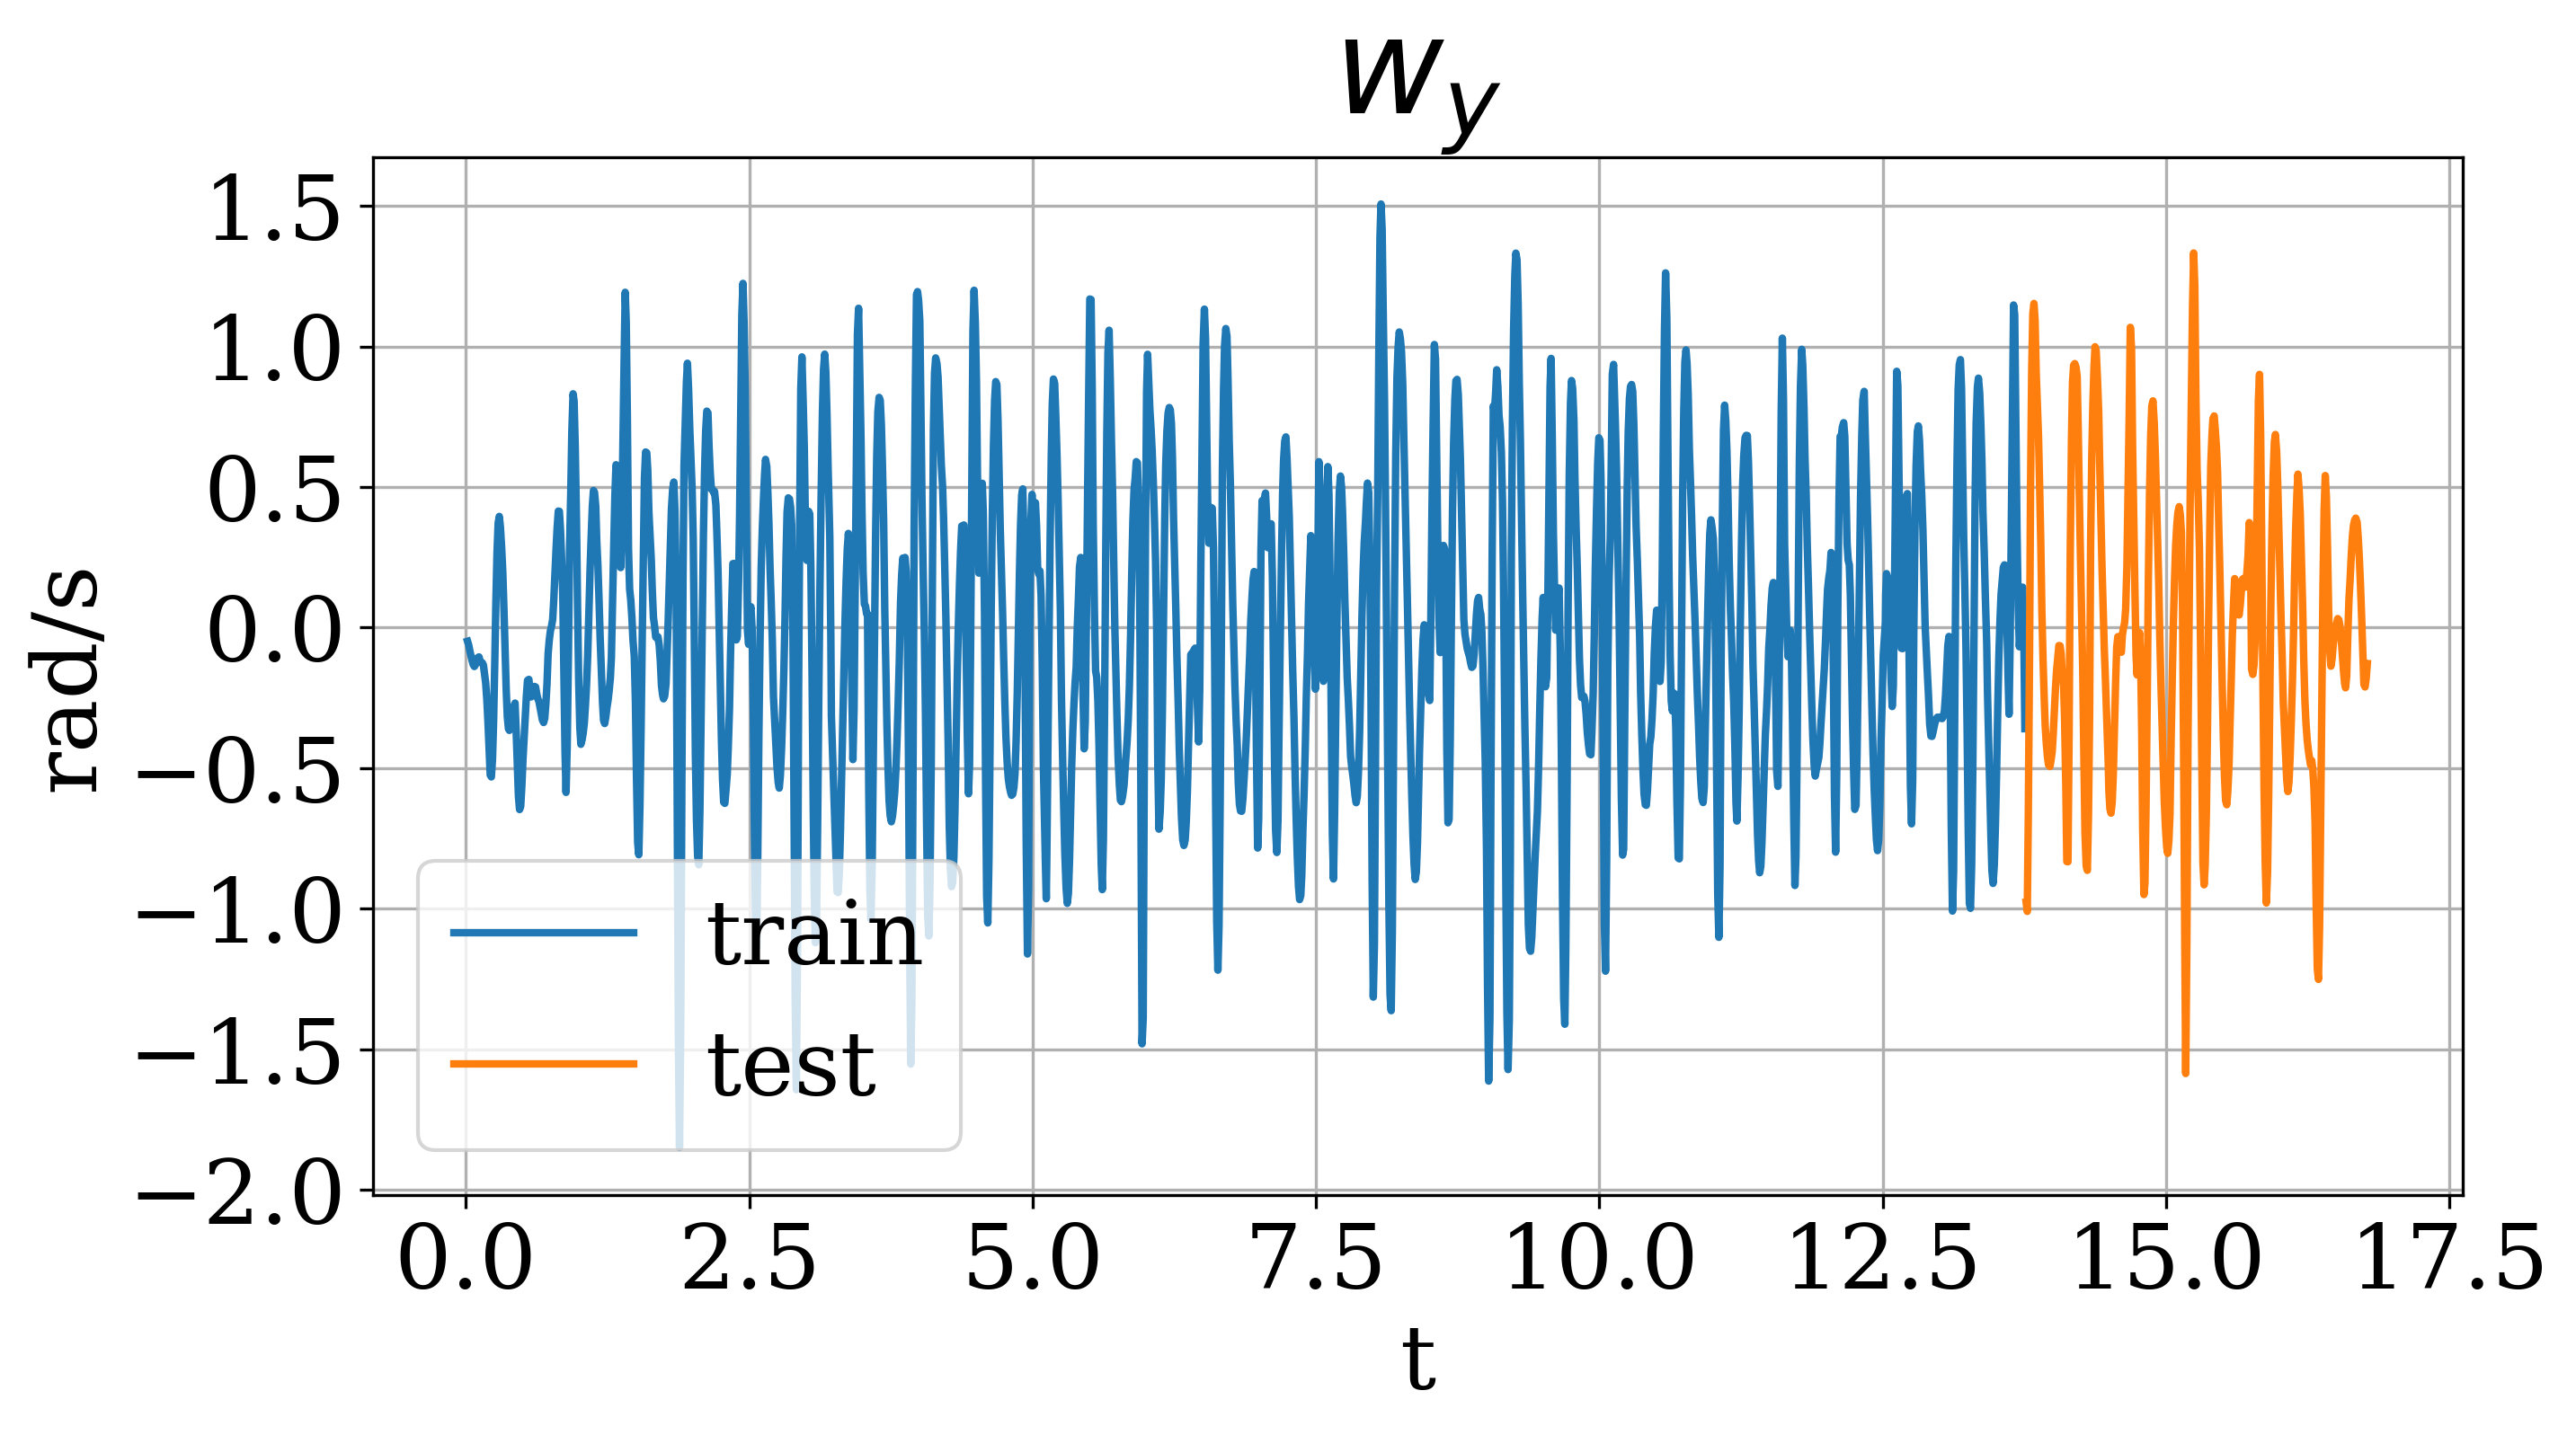

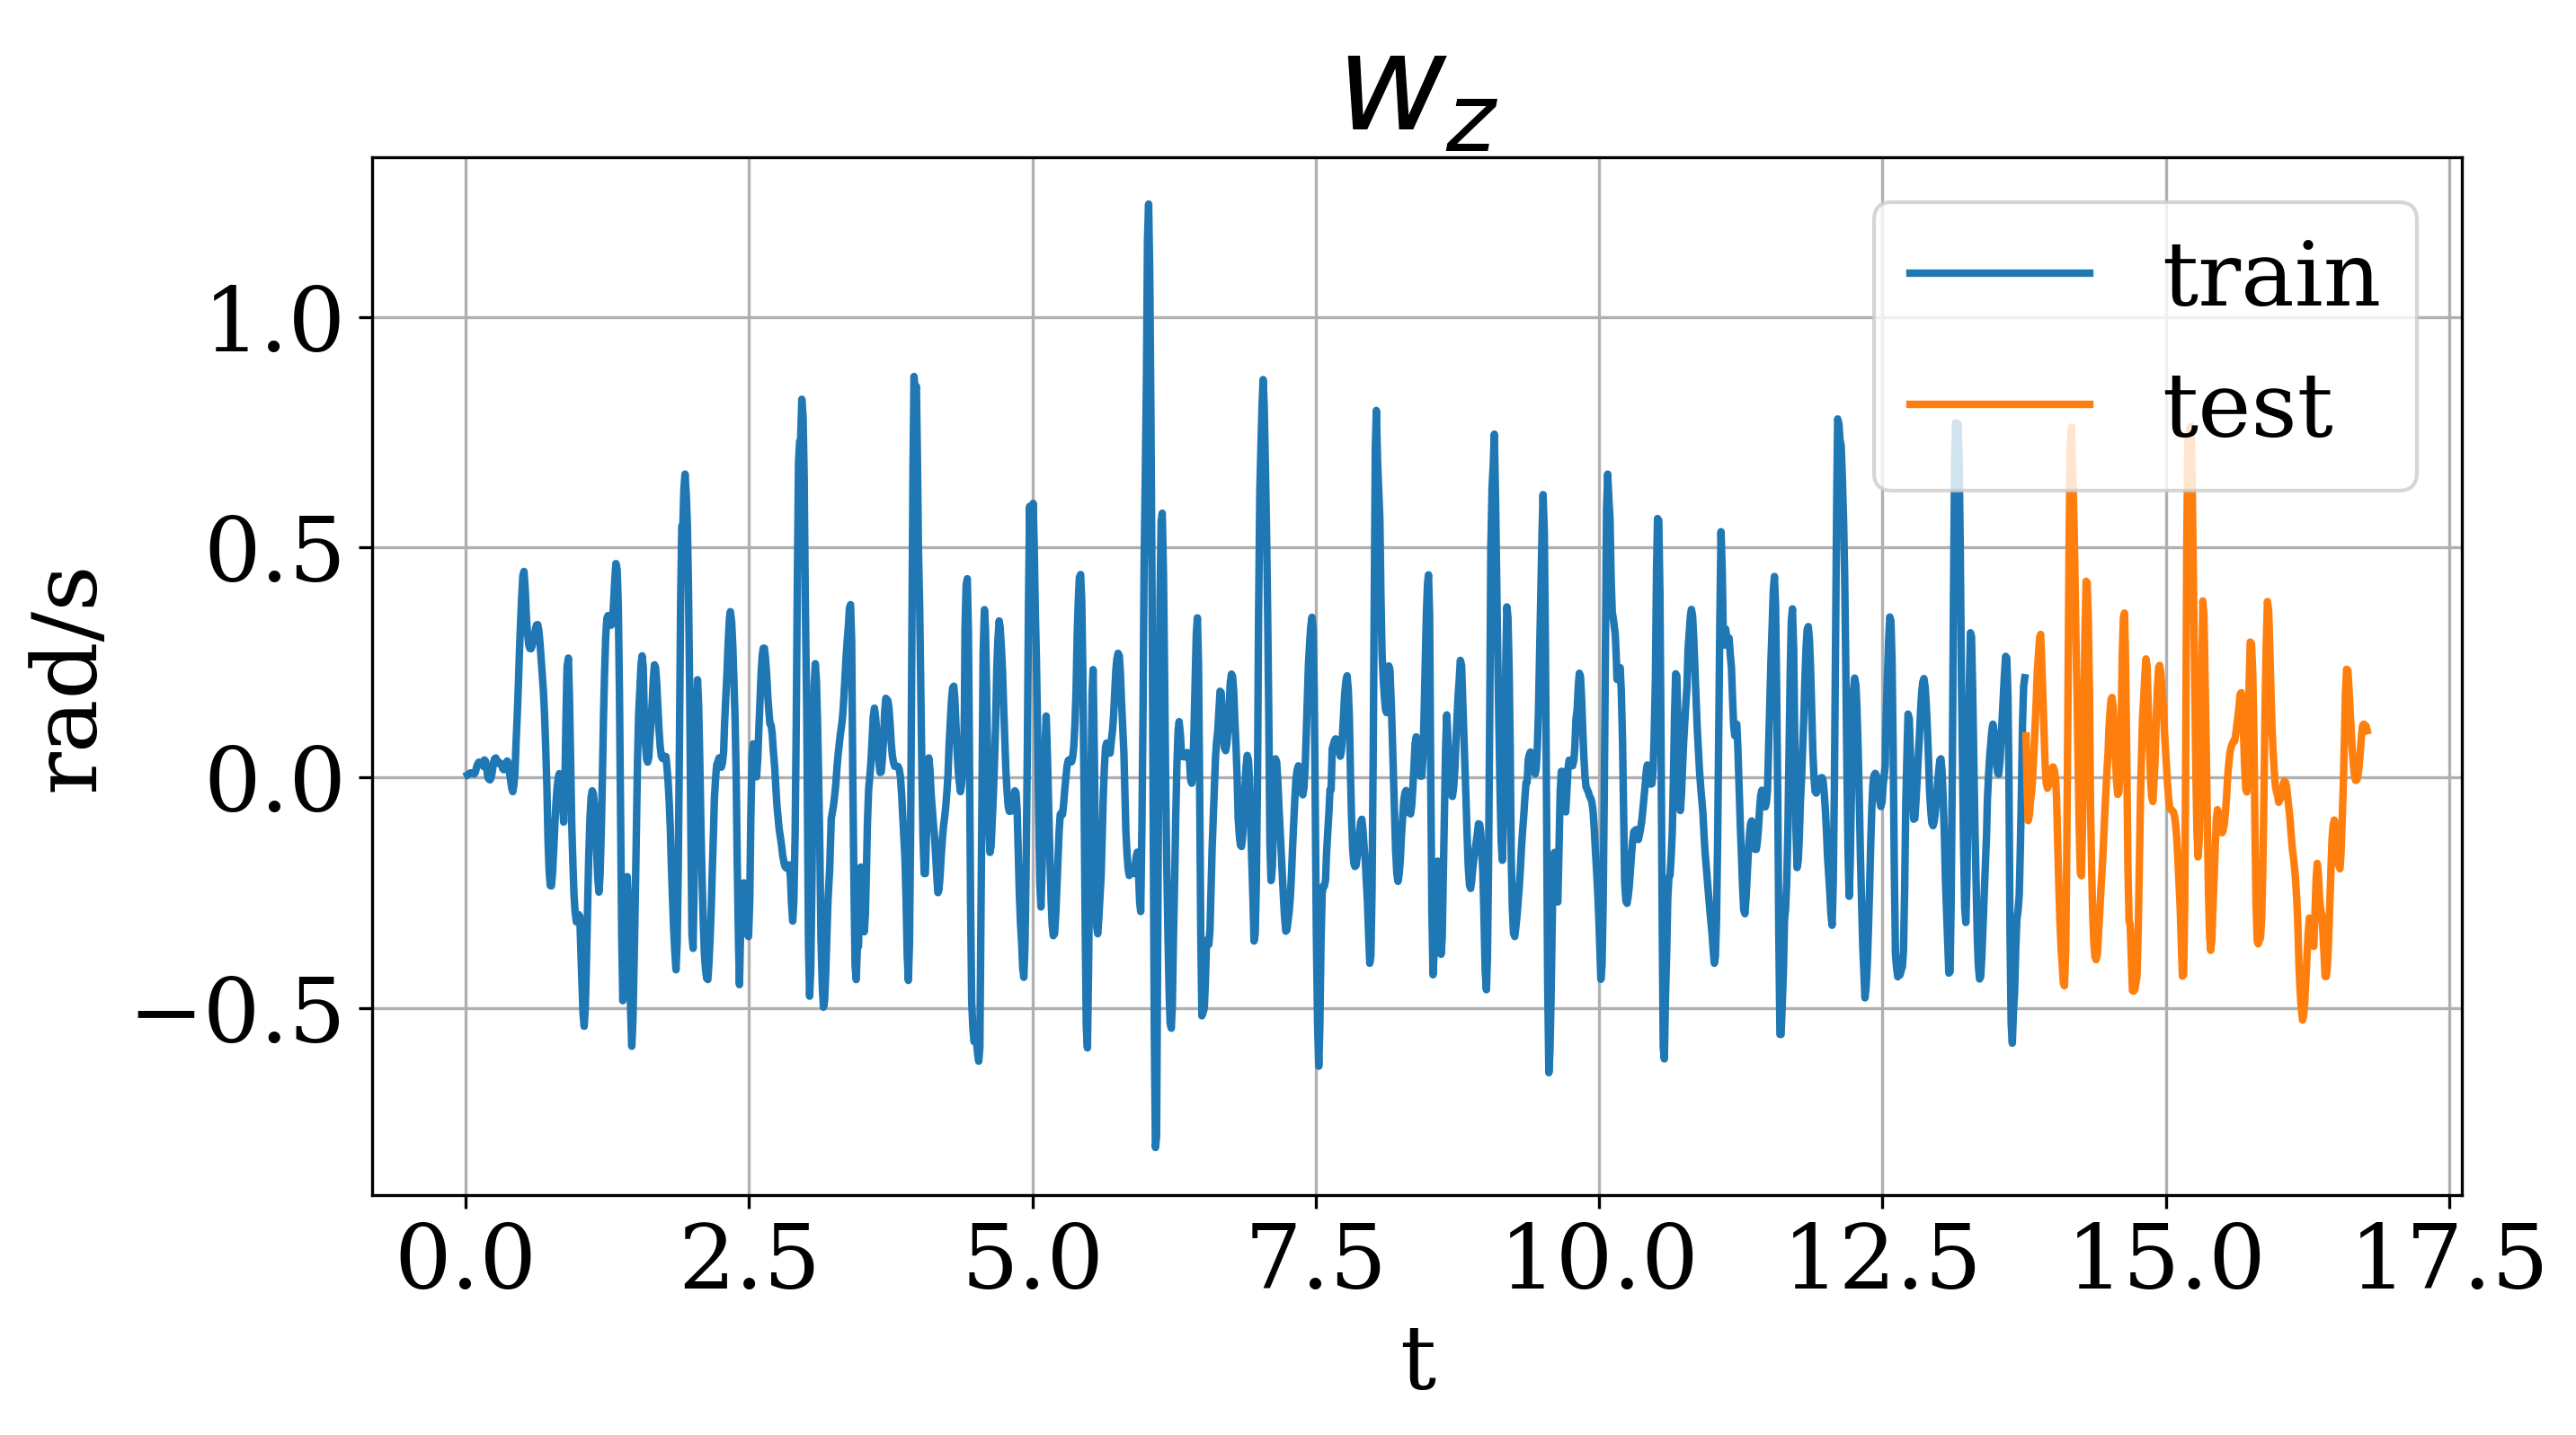

In [8]:
# draw signals
for i in range(num_signals):
    with EnableJournalStylePlotting():
        fig, ax = plt.subplots(figsize=(10, 5))

        ax.plot(time_grid_train, train_data.T[i], label='train')
        ax.plot(time_grid_test, test_data.T[i], label='test')

        ax.grid(True)
        ax.legend()
        ax.set_xlabel('t')
        ax.set_ylabel(sig_units[i])
        ax.set_title(sig_names[i])

## Global method parameters

In [9]:
# for consitency along diffrent methods they share alike parameters
num_lags = 1000

## VAR fitting

In [10]:
# make directory for models
pathlib.Path(f'./saved_model').mkdir(parents=True, exist_ok=True)

In [11]:
# load model if it already exists
if pathlib.Path(f'./saved_model/var_model.pkl').exists():
    with open(f'./saved_model/var_model.pkl', 'rb') as f:
        var_result = pickle.load(f)
else:
    var_model = VAR(train_data)

    var_result = var_model.fit(num_lags)

    # save model
    with open(f'./saved_model/var_model.pkl', 'wb') as f:
        pickle.dump(var_result, f)

In [12]:
#var_result.summary()

## Predicition

In [13]:
# colours for our signals (https://colorhunt.co/palette/808836ffbf00ff9a00d10363)
color_list = ['#808836', '#FFBF00', '#FF9A00', "#D10363", "#6C0345", "#DC6B19", "#01204E"]

In [14]:
# make directory for figures
pathlib.Path(f'./figs/prediction').mkdir(parents=True, exist_ok=True)

In [15]:
# obtain last num_lags values before test values to create forecast 
train_last_values = train_data[-num_lags:]
var_forecast = var_result.forecast(train_last_values, test_data.shape[0])

In [16]:
var_forecast.shape

(302, 6)

In [17]:
# count metrics
var_mse_metric = np.mean((var_forecast - test_data) ** 2, axis=0)
var_mape_metric = np.mean(np.abs((var_forecast - test_data) / test_data), axis=0)

print(f'MSE = {var_mse_metric}\nMAPE = {var_mape_metric}')
print(f'MSE_mean = {np.mean(var_mse_metric)}\nMAPE_mean = {np.mean(var_mape_metric)}')

# create dataframe for metrics
metrics_frame = pd.DataFrame({'MSE': [var_mse_metric], 'MAPE': [var_mape_metric]}, index=['VAR']).to_csv()

MSE = [10.07996044  5.66177637  8.58345158  1.51567413  0.29909685  0.07952113]
MAPE = [ 2.11612768  3.03874658  4.95627843 21.15317111  5.30424192  4.82254209]
MSE_mean = 4.369913416142693
MAPE_mean = 6.898517967473272


In [18]:
print(f'Acc MSE: {np.mean(var_mse_metric[:3])}')
print(f'Acc MAPE: {np.mean(var_mape_metric[:3])}')

print(f'Gyro MSE: {np.mean(var_mse_metric[3:])}')
print(f'Gyro MAPE: {np.mean(var_mape_metric[3:])}')

Acc MSE: 8.108396130549588
Acc MAPE: 3.3703842291235495
Gyro MSE: 0.6314307017357983
Gyro MAPE: 10.426651705822996


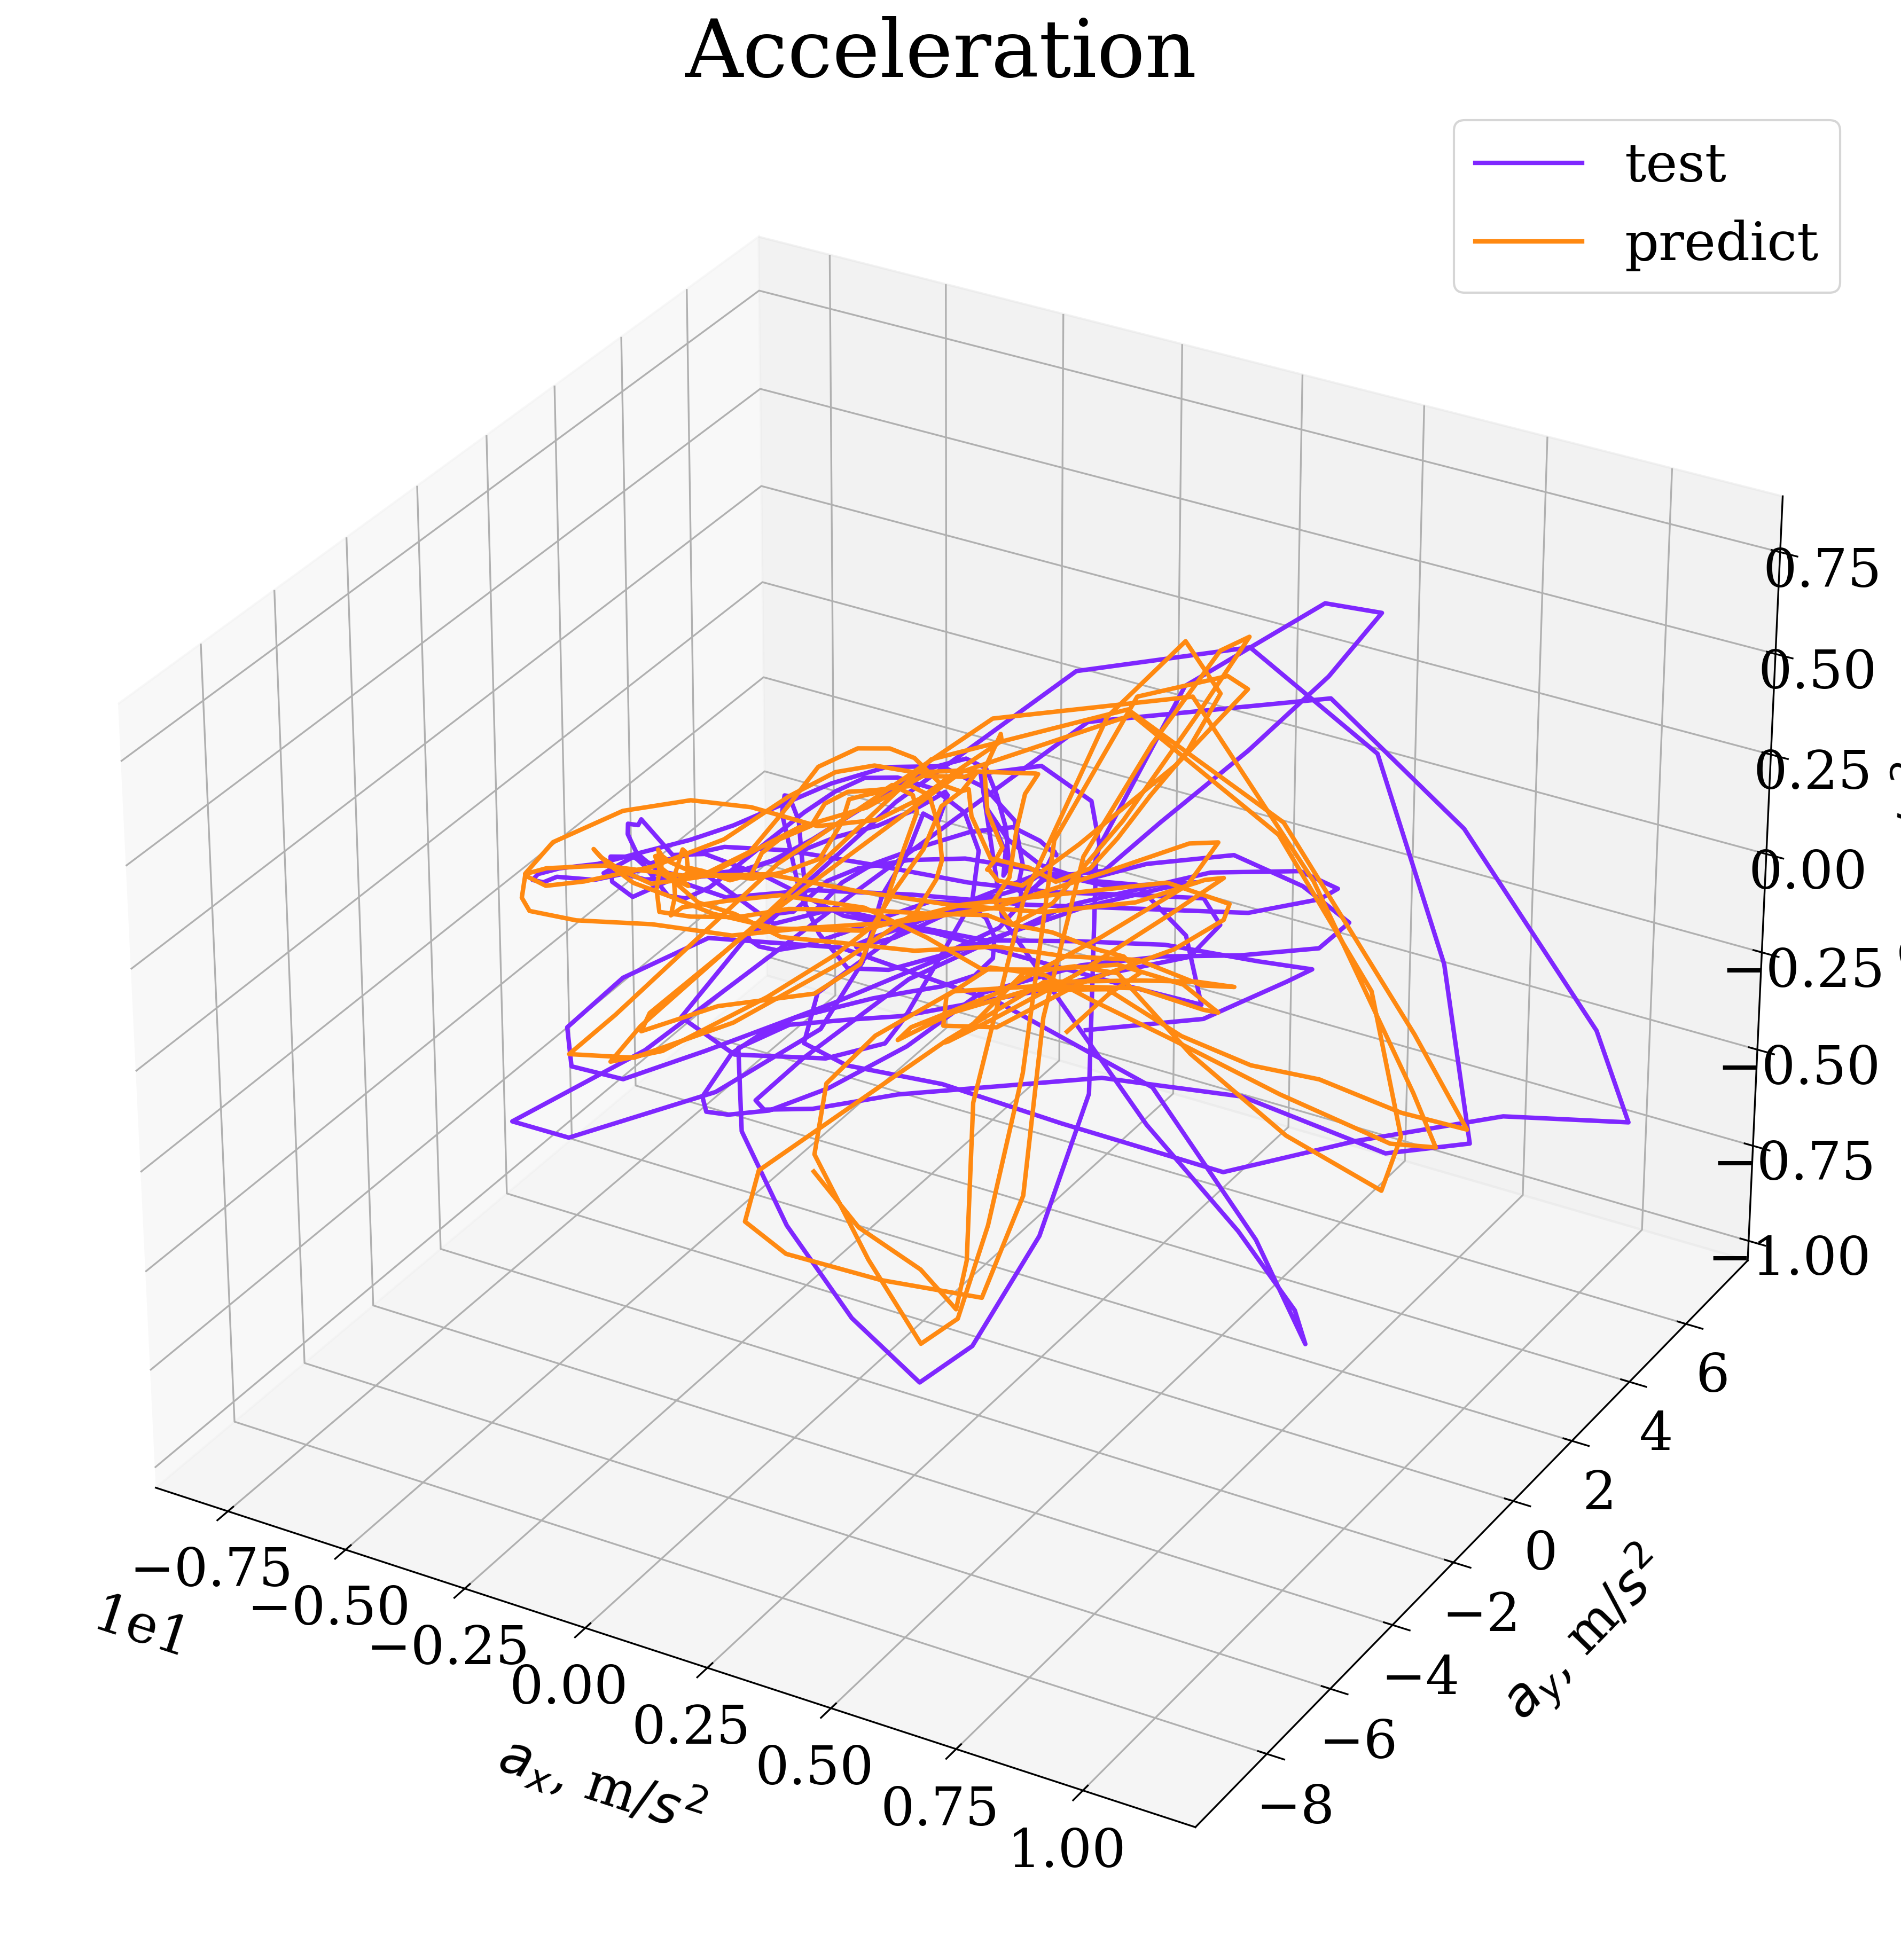

In [19]:
# 3d acceler plots
component_colors = ["#7F27FF", "#FF8911"]

# make directory for figures
pathlib.Path(f'./figs/prediction').mkdir(parents=True, exist_ok=True)

with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(projection='3d')

    ax.plot(*(test_data.T[:3]), color=component_colors[0], label="test")
    ax.plot(*(var_forecast.T[:3]), color=component_colors[1], label="predict")

    ax.set_xlabel(f"{sig_names[0]}, {sig_units[0]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[1]}, {sig_units[1]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[2]}, {sig_units[2]}", labelpad=21)
    ax.set_title(f"Acceleration")
    ax.legend()

    for axis in ["x", "y", "z"]:
        ax.ticklabel_format(axis=axis, style="scientific", scilimits=(0, 0))
    
    fig.savefig(f"./figs/prediction/acceler.png", format='png')

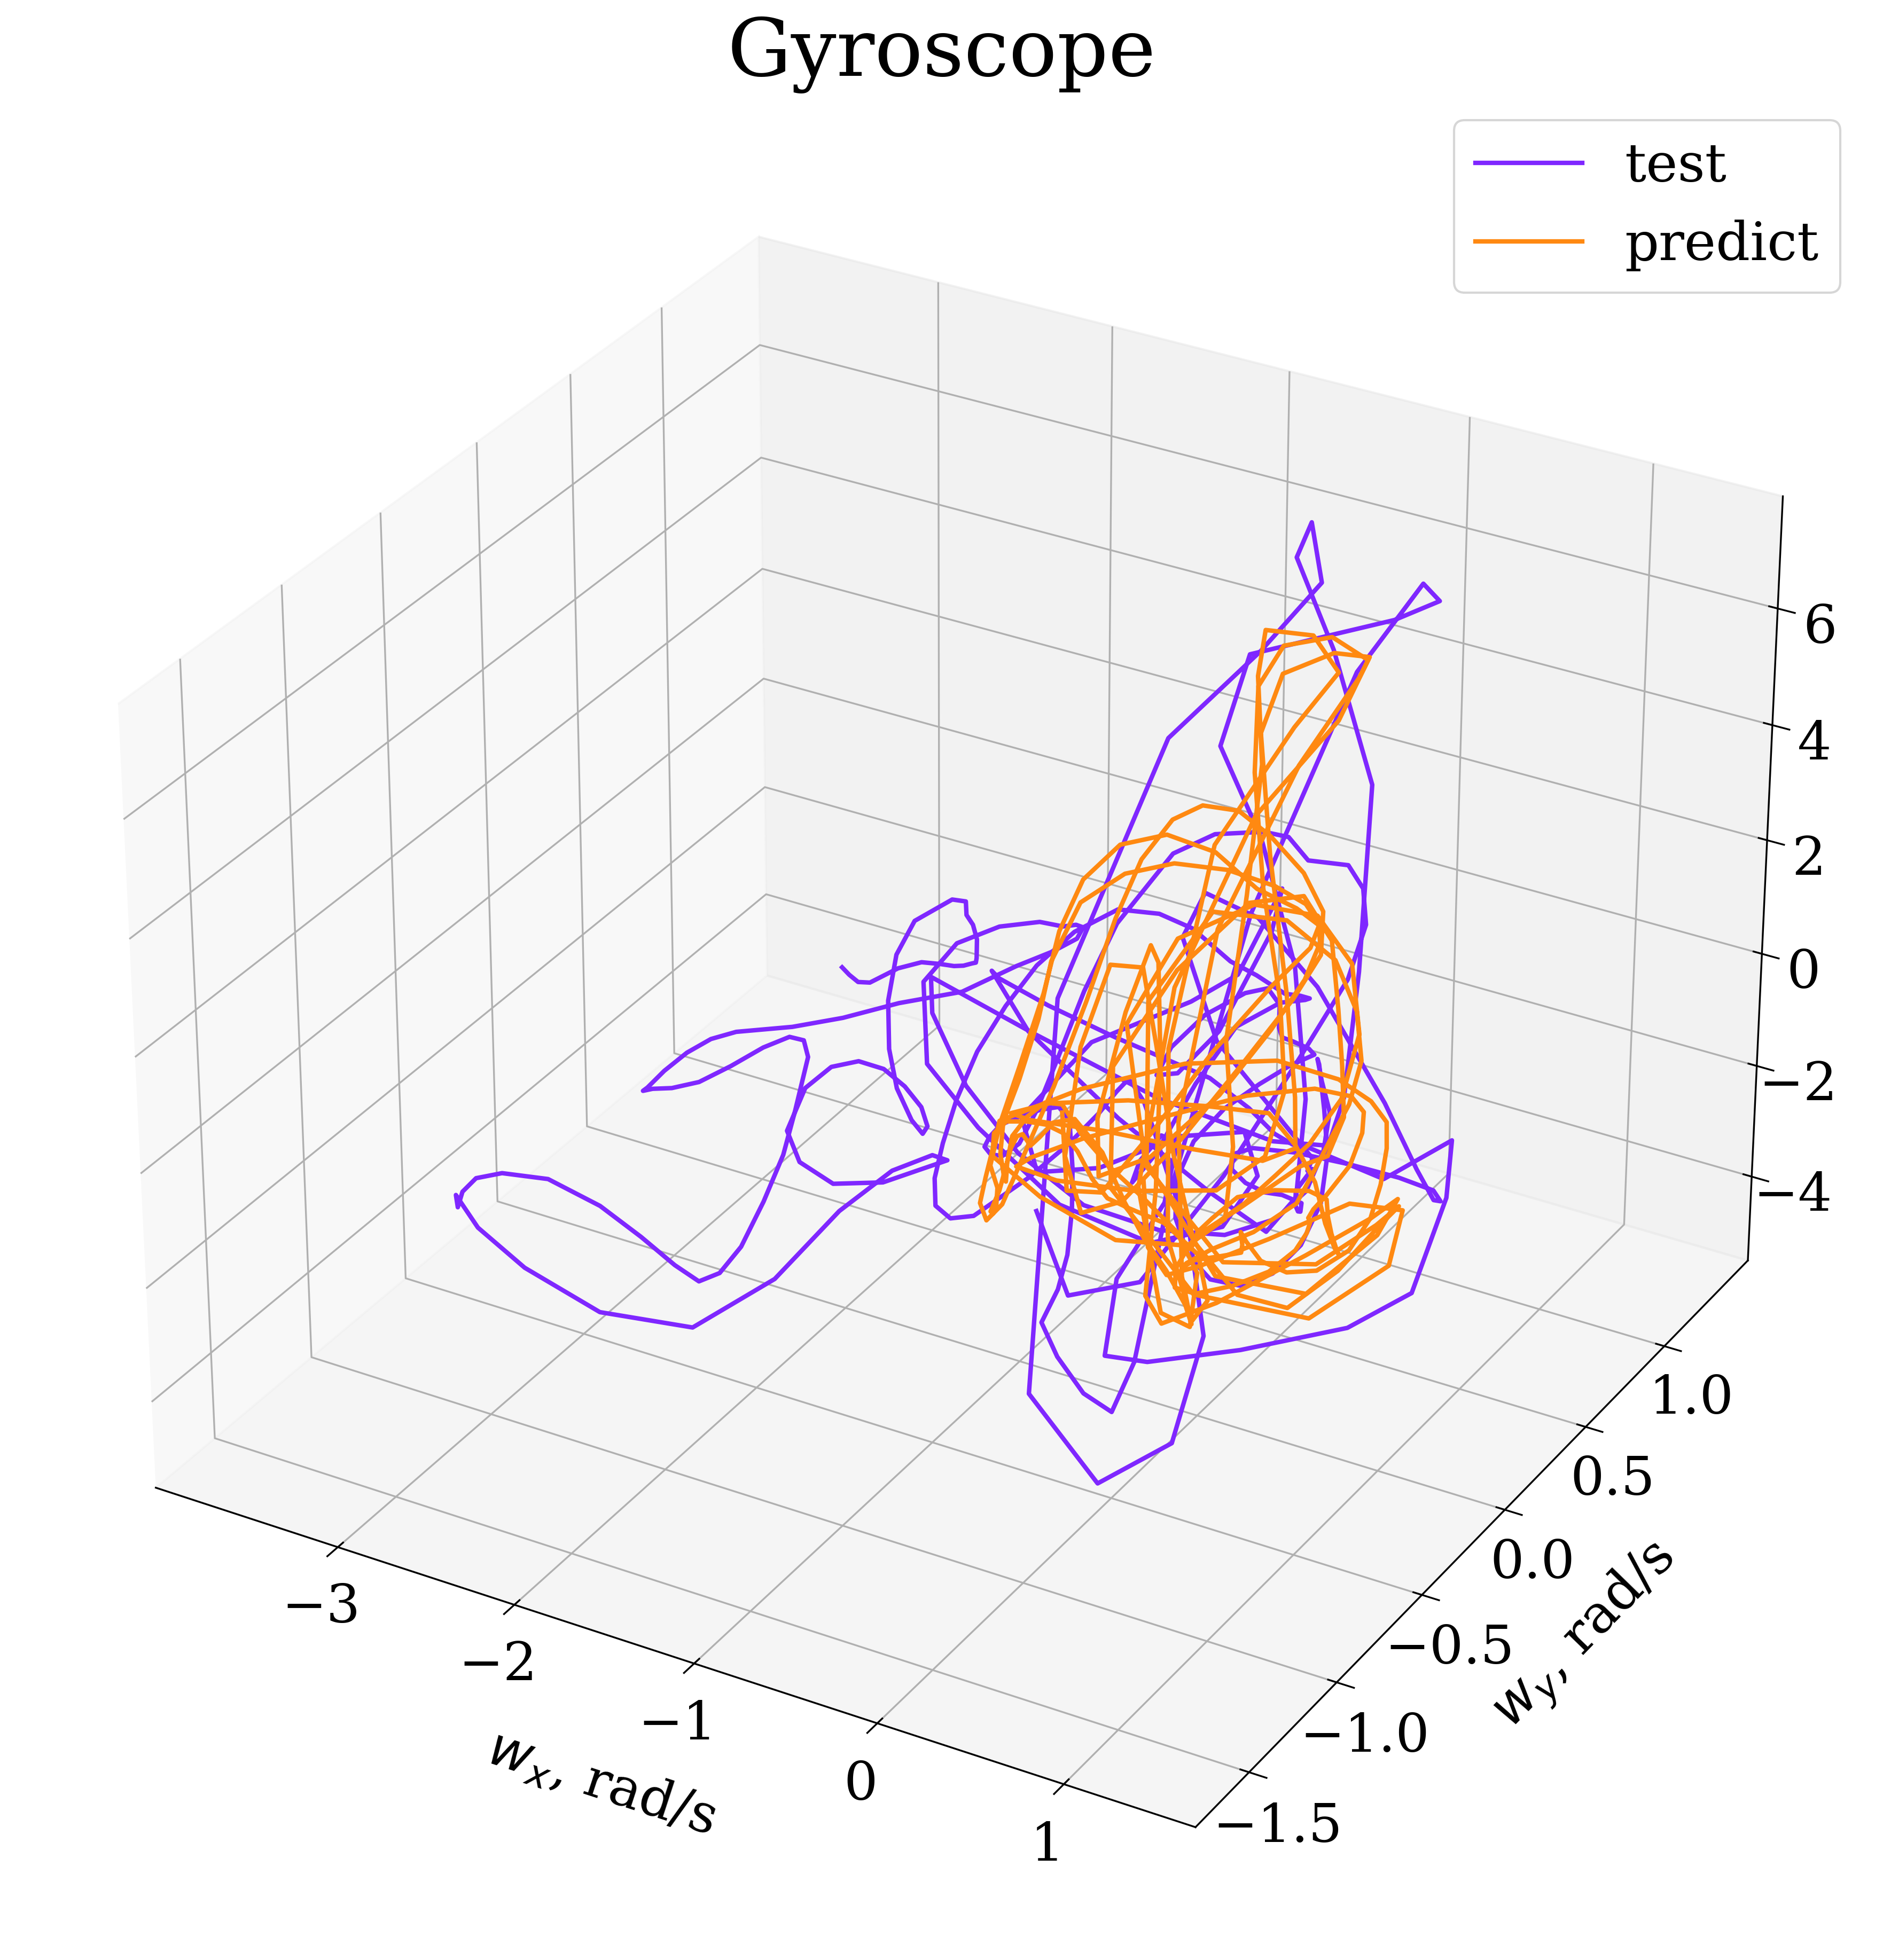

In [20]:
# 3d gyro plots
component_colors = ["#7F27FF", "#FF8911"]

with EnableJournalStylePlotting():
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(projection='3d')

    ax.plot(*(test_data.T[3:]), color=component_colors[0], label="test")
    ax.plot(*(var_forecast.T[3:]), color=component_colors[1], label="predict")

    ax.set_xlabel(f"{sig_names[3]}, {sig_units[3]}", labelpad=21)
    ax.set_ylabel(f"{sig_names[4]}, {sig_units[4]}", labelpad=21)
    ax.set_zlabel(f"{sig_names[5]}, {sig_units[5]}", labelpad=21)
    ax.set_title(f"Gyroscope")
    ax.legend()

    for axis in ["x", "y", "z"]:
        ax.ticklabel_format(axis=axis, style="scientific", scilimits=(0, 0))
    
    fig.savefig(f"./figs/prediction/gyro.png", format='png')